# Module 7: Volatility Models (ARCH($p$), GARCH($p$, $q$) + extensions), Principal Component Analysis (PCA)

For this module session, we'll be taking a closer look at the volatility models with some examples, as well as dimensionality reduction techniques (i.e. **PCA**). 

As usual, we start by importing all of the necessary Python packages/libraries. 

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
### Imports: from Python 3.7
from __future__ import print_function, division

### Imports: pandas', 'numpy'
import pandas as pd
import numpy as np

### Imports: 'statsmodels'
import statsmodels.api as sm
from statsmodels import tsa
from statsmodels.tools.eval_measures import mse, rmse, meanabs
from statsmodels import multivariate

### Imports: Date-related libraries 'datetime', 'calendar'
import datetime as dt
import dateutil
import copy

### Imports: Plotting libraries 'matplotlib' & 'seaborn'
from cycler import cycler
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import matplotlib.dates as mdates
import seaborn.apionly as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Imports: other
from IPython.display import display, HTML
def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    CSS = """.output {vertical-align: middle;}"""
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
        '<style>{}</style>'.format(CSS)
    )
from ipy_table import*

### Plotting and display options
np.set_printoptions(precision=3)
pd.set_option('precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.color'] = 'blue'
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['#30a2da', '#e5ae38', '#fc4f30', '#6d904f', '#8b8b8b'])
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['axes.facecolor'] = '#f0f0f0'
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['axes.labelpad'] = 0.0
mpl.rcParams['axes.xmargin'] = 0.05  # x margin. See `axes.Axes.margins`
mpl.rcParams['axes.ymargin'] = 0.05  # y margin. See `axes.Axes.margins`
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['figure.subplot.left'] = 0.08
mpl.rcParams['figure.subplot.right'] = 0.95
mpl.rcParams['figure.subplot.bottom'] = 0.07


# figure configuration
fsize = (10,7.5) # figure size
tsize = 18 # title font size
lsize = 16 # legend font size
csize = 14 # comment font size
grid = True # grid

# this allows plots to appear directly in the notebook
%matplotlib inline

/Users/chris.jauregui/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/chris.jauregui/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/Users/chris.jauregui/anaconda3/lib/python3.7/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In addition, we will import the `arch` package see [online documentation](https://pypi.org/project/arch/) written [Kevin Sheppard](https://www.kevinsheppard.com/Main_Page). 

In [3]:
### Import 'arch'
import arch
from arch import arch_model
print (arch.__version__)

4.8.1


# Exercise 1:

Let's download daily prices of the **S&P500 index**, **General Electric (GE)** and **International Business Machines (IBM)** from [Yahoo! Finance](https://finance.yahoo.com/) starting in **1970**. 

We can access the data remotely using the **Yahoo! Finance** API that is part of `pandas-datareader`. It is important that we pass the `start` datetime argument to the function so we pull data before 2010. To start, we will download the historical daily data since 1950 for each equity instrument. We can then select data starting in 1970 using `pandas` datetime indexing.


In [1]:
### =True if accessing data remotely.
access_yahoo = False

if access_yahoo:
    from distutils.version import StrictVersion
    if StrictVersion(pd.__version__) >= StrictVersion('0.19'):
        import pandas_datareader.data as web
    else:
        import pandas.io.data as web
    
    ### Keep 'close prices'only
    tickers = ['^GSPC', 'GE', 'IBM']
    tickers_field = 'Adj Close' 
    tickers_tup = [(tickers_field, tic) for tic in tickers]

    dfyf =  web.get_data_yahoo(tickers, start=dt.date(1950,1,1))  
    dfyf_cp = dfyf.loc[:, tickers_tup]
    dfyf_cp.columns = dfyf_cp.columns.droplevel()
    dfyf_cp = dfyf_cp.asfreq('d').dropna()
    
    ### Save file to .csv
    dfyf_cp.to_csv('YahooFinance_AdjClose_fullsample.csv')
    dfyf_cp.rename(columns={'^GSPC':'S&P500'}, inplace=True)
       
else:
    dfyf_cp = pd.read_csv('YahooFinance_AdjClose_fullsample.csv', index_col=['Date'])
    dfyf_cp.index = pd.to_datetime(dfyf_cp.index)
    dfyf_cp = dfyf_cp.asfreq('d').dropna()
    dfyf_cp.rename(columns={'^GSPC':'S&P500'}, inplace=True)

startdate = '1970-1-1'
dfyf_cp = dfyf_cp.loc[startdate:, :]
    
display(dfyf_cp.info())
display(multi_table([dfyf_cp.head(), dfyf_cp.tail()]))

NameError: name 'pd' is not defined

## Exercise 1 (Part A):

Construct *daily*, *monthly*, and *annual* (log) returns from prices: 

**Step 1:** Construct the following volatility measures and compare them:
   1. Average Annualized volatility of *daily* returns.
   2. Average Annualized volatility of *monthly* returns.
   3. Average volatility of *annual* returns (which is annualized by construction!)

**Step 2:** Next, compare the <u>time-series</u> of:
   1. **Realized volatility** of *daily* returns.
   2. **Realized volatility** of *monthly* returns.
   3. **Realized volatility** of *annual* returns.
   2. Monthly **realized volatility** based on *daily* returns in each month.
    
   Plot these series and compute their means, variances and correlation.

### Solution to Exercise 1 (Part A):

Let's create *daily*, *monthly*, and *annual* returns (in %) as log differences of prices. We get them in % by multiplying by 100:

In [5]:
### DAILY log returns
ret_d = pd.DataFrame(np.log(dfyf_cp).diff(1)*100)
ret_d = ret_d.dropna()

ret_d_summ = pd.concat([ret_d.describe()], axis=1, keys=['Daily'])
ret_d_summ.loc['count'] = ret_d_summ.loc['count'].apply('{:.0f}'.format)

display(multi_table([ret_d.head(), ret_d.tail()]))

In [6]:
### MONTHLY log returns (from end-of-month)
dfyf_cp_eom = dfyf_cp.resample('M').last()
ret_eom = pd.DataFrame(np.log(dfyf_cp_eom).diff(1)*100)
ret_eom = ret_eom.dropna()

ret_eom_summ = pd.concat([ret_eom.describe()], axis=1, keys=['End-of-Month'])  
ret_eom_summ.loc['count'] = ret_eom_summ.loc['count'].apply('{:.0f}'.format)

display(multi_table([ret_eom.head(), ret_eom.tail()]))

In [7]:
### ANNUAL log returns (from end-of-year)
dfyf_cp_eoy = dfyf_cp.resample('Y').last()
ret_eoy = pd.DataFrame(np.log(dfyf_cp_eoy).diff(1)*100)
ret_eoy = ret_eoy.dropna()

ret_eoy_summ = pd.concat([ret_eoy.describe()], axis=1, keys=['End-of-Year']) 
ret_eoy_summ.loc['count'] = ret_eoy_summ.loc['count'].apply('{:.0f}'.format)

display(multi_table([ret_eoy.head(), ret_eoy.tail()]))

Summary statistics for all three log return frequencies: 

In [8]:
multi_table([ret_d_summ, ret_eom_summ, ret_eoy_summ])

#### Step 1:  

The average annualized volatility of *daily* and *monthly* log returns, as well as the average volatility of *annual* returns is given by the **sample standard deviation** (adjusted by the appropriate frequency multiplier), shown in the table below.

Later, we will look at **realized volatility**...

In [9]:
multi_table([(252**0.5)*ret_d_summ.loc[['std']], (12**0.5)*ret_eom_summ.loc[['std']], ret_eoy_summ.loc[['std']]])

In [10]:
def create_hist_data(stock, stock_ticker, freq, axes, startdate=None, enddate=None, lw=0.15, x=0):
    #years = mdates.YearLocator(10)
    axes[x].plot(stock.loc[startdate:enddate], lw=lw)
    axes[x].set_title(stock_ticker+' : '+freq, fontsize=18)
    axes[x].set_xlabel('Years', fontsize=16)
    axes[x].set_ylabel('Return (%)', fontsize=16) 
    #axes[x].xaxis.set_major_locator(years)
    x = x + 1
    return x

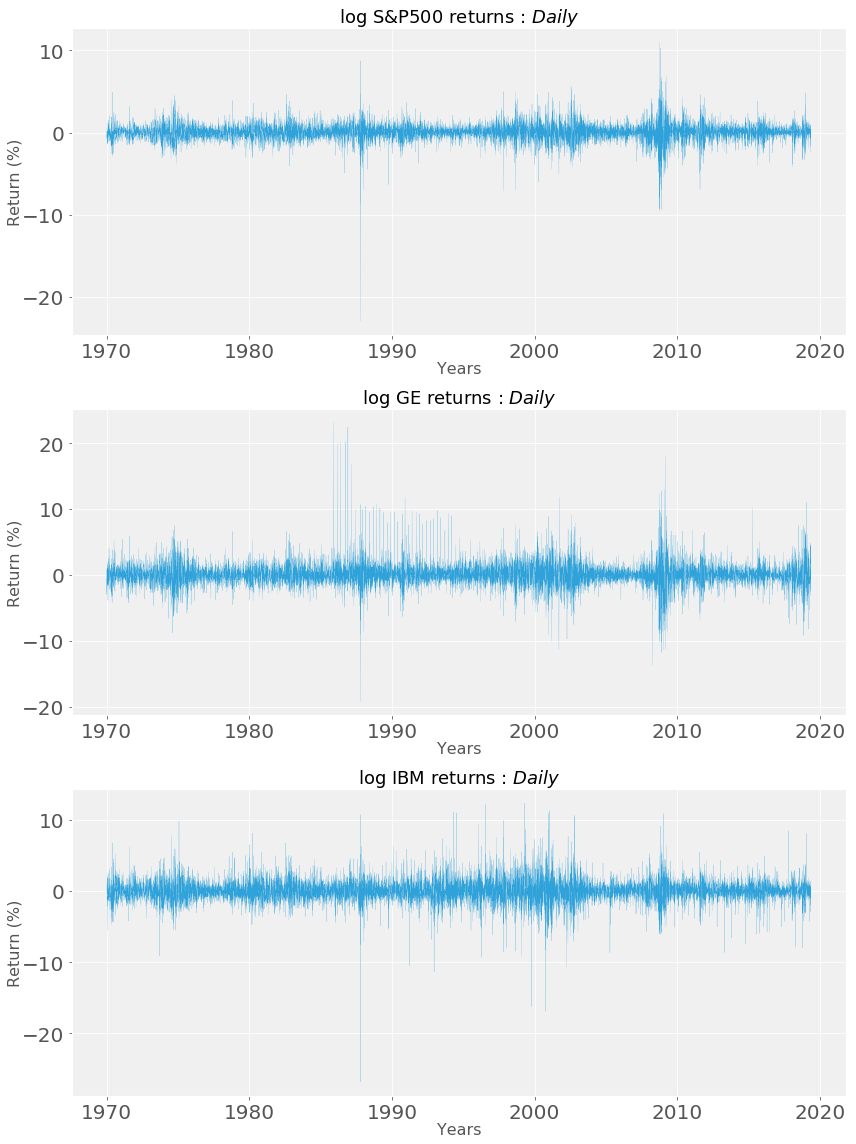

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 16))  
plt.subplots_adjust(hspace=0.5, wspace=0.5)
axes_idx = create_hist_data(stock=ret_d['S&P500'], stock_ticker='log S&P500 returns', 
                            freq='$Daily$', axes=axes, x=0)
axes_idx = create_hist_data(stock=ret_d['GE'], stock_ticker='log GE returns', 
                            freq='$Daily$', axes=axes, x=axes_idx)
axes_idx = create_hist_data(stock=ret_d['IBM'], stock_ticker='log IBM returns', 
                            freq='$Daily$', axes=axes, x=axes_idx)
fig.tight_layout()

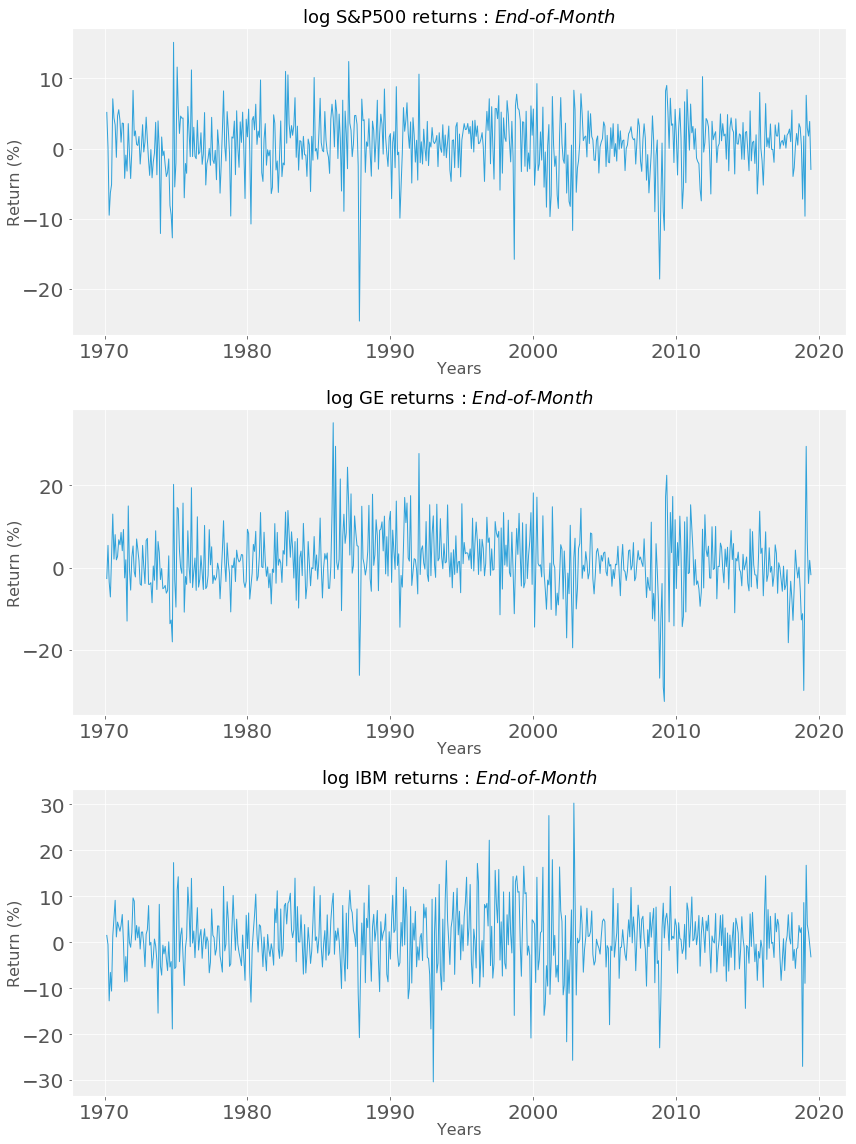

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 16))  
plt.subplots_adjust(hspace=0.5, wspace=0.5)
axes_idx = create_hist_data(stock=ret_eom['S&P500'], stock_ticker='log S&P500 returns', freq='$End$-$of$-$Month$', 
                            axes=axes, lw=1, x=0)
axes_idx = create_hist_data(stock=ret_eom['GE'], stock_ticker='log GE returns', freq='$End$-$of$-$Month$', 
                            axes=axes, lw=1, x=axes_idx)
axes_idx = create_hist_data(stock=ret_eom['IBM'], stock_ticker='log IBM returns', freq='$End$-$of$-$Month$', 
                            axes=axes, lw=1, x=axes_idx)
fig.tight_layout()

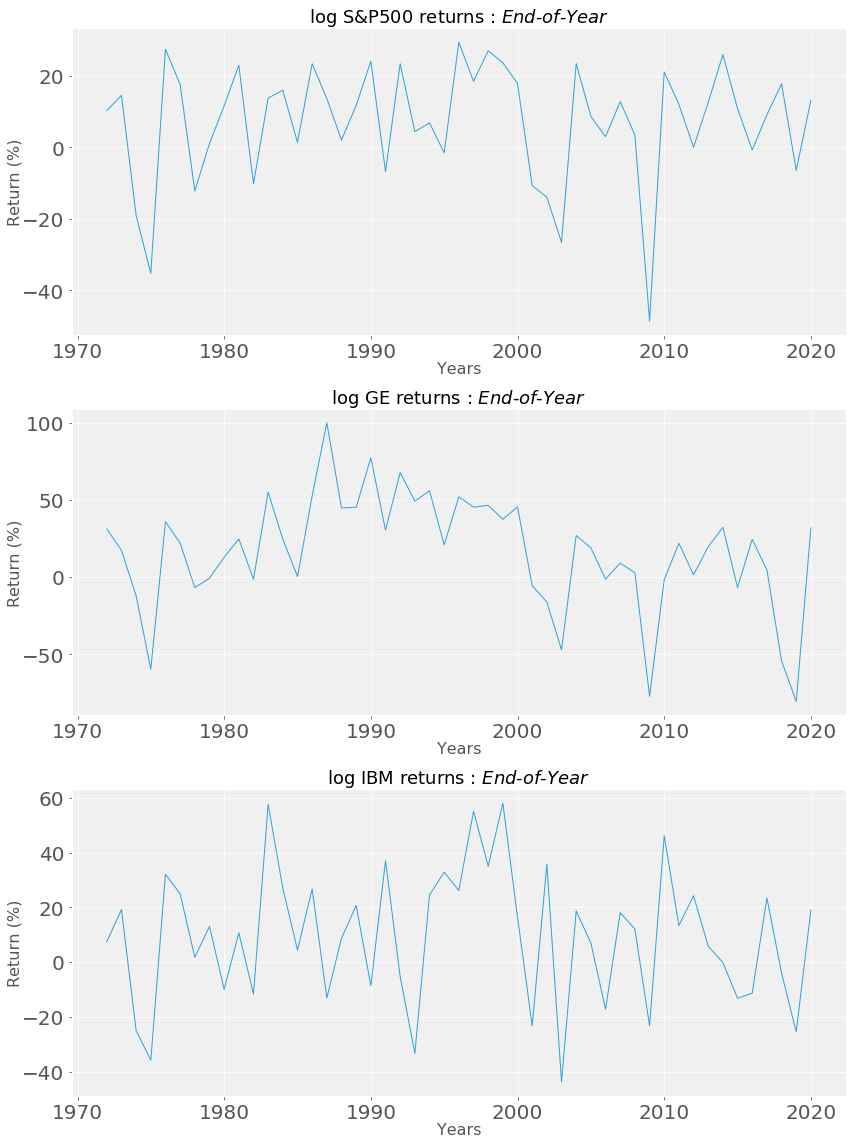

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 16))  
plt.subplots_adjust(hspace=0.5, wspace=0.5)
axes_idx = create_hist_data(stock=ret_eoy['S&P500'], stock_ticker='log S&P500 returns', freq='$End$-$of$-$Year$', 
                            axes=axes, lw=1, x=0)
axes_idx = create_hist_data(stock=ret_eoy['GE'], stock_ticker='log GE returns', freq='$End$-$of$-$Year$', 
                            axes=axes, lw=1, x=axes_idx)
axes_idx = create_hist_data(stock=ret_eoy['IBM'], stock_ticker='log IBM returns', freq='$End$-$of$-$Year$', 
                            axes=axes, lw=1, x=axes_idx)
fig.tight_layout()

#### Step 2:  
Let's construct the following time series:
   1. **Realized volatility** of *daily* returns.
   2. **Realized volatility** of *monthly* returns.
   3. **Realized volatility** of *annual* returns.
   2. Monthly **realized volatility** based on *daily* returns in each month.

Since *monthly* returns are <u>end-of-month</u>, to differentiate **realized volatility of monthly returns** from **realized monthly volatility from daily returns**, `DataFrame`s (and any related objects) arising from the former have `eom` in the object name, while the latter have `m`.

Now, let's computed **realized monthly volatility from daily returns**. We do this via the formula:

$$
\begin{align*}
  RVol_{t} = \sqrt{\sum_{d\in t}r_{d,t}^2}
\end{align*}  
$$

where $d$ indexes business days in month $t$. To annualize, we multiply $ RVol_{t}$ by $\sqrt{12}$. For any *daily* realized volatility measures, we would instead multiply by $\sqrt{252}$, which are the number of trading days in a year. Note, this expression assumes a mean of zero, which is a reasonable approximation for high frequency financial time series.

In [14]:
RVol_m = ret_d.resample('M').apply(lambda x: np.sum(x**2)**0.5)

Let's look at summary statistics for all 4 of our time series (annualized) volatility measures for **S&P500 Index**, **GE**, and **IBM**

In [15]:
aret_RVol_d   = (252**0.5)*np.abs(ret_d)
aret_RVol_eom = (12**0.5)*np.abs(ret_eom)
aret_RVol_eoy = np.abs(ret_eoy)
aret_RVol_m   = (12**0.5)*RVol_m

aret_RVol_d_summ = pd.concat([aret_RVol_d.describe()], axis=1, keys=['$Daily$']) 
aret_RVol_d_summ.loc['count'] = aret_RVol_d_summ.loc['count'].apply('{:.0f}'.format)

aret_RVol_eom_summ = pd.concat([aret_RVol_eom.describe()], axis=1, keys=['$End$-$of$-$Month$']) 
aret_RVol_eom_summ.loc['count'] = aret_RVol_eom_summ.loc['count'].apply('{:.0f}'.format)

aret_RVol_m_summ = pd.concat([aret_RVol_m[1:].describe()], axis=1, keys=['$Monthly$ from $Daily$']) 
aret_RVol_m_summ.loc['count'] = aret_RVol_m_summ.loc['count'].apply('{:.0f}'.format)

aret_RVol_eoy_summ = pd.concat([aret_RVol_eoy.describe()], axis=1, keys=['$End$-$of$-$Year$']) 
aret_RVol_eoy_summ.loc['count'] = aret_RVol_eoy_summ.loc['count'].apply('{:.0f}'.format)

In [16]:
multi_table([aret_RVol_d_summ, aret_RVol_eom_summ, aret_RVol_m_summ, aret_RVol_eoy_summ])

Just looking at the **time-series average**...

In [17]:
multi_table([aret_RVol_d_summ.loc[['mean']], aret_RVol_eoy_summ.loc[['mean']],
             aret_RVol_eom_summ.loc[['mean']], aret_RVol_m_summ.loc[['mean']]])

Let's look at the correlation between the two (annualized) *monthly* measures:
   1. **Realized volatility** of *monthly* returns.
   2. Monthly **realized volatility** based on *daily* returns in each month.


In [18]:
for ticker in ret_eom.columns:
    print('**** '+ticker+' ****')
    display(np.corrcoef(aret_RVol_eom[ticker], 
                        aret_RVol_m[1:][ticker]).squeeze())

**** S&P500 ****


array([[1.   , 0.552],
       [0.552, 1.   ]])

**** GE ****


array([[1.   , 0.609],
       [0.609, 1.   ]])

**** IBM ****


array([[1.   , 0.571],
       [0.571, 1.   ]])

For each ticker, let's plot all 4 time-series from before (annualized):


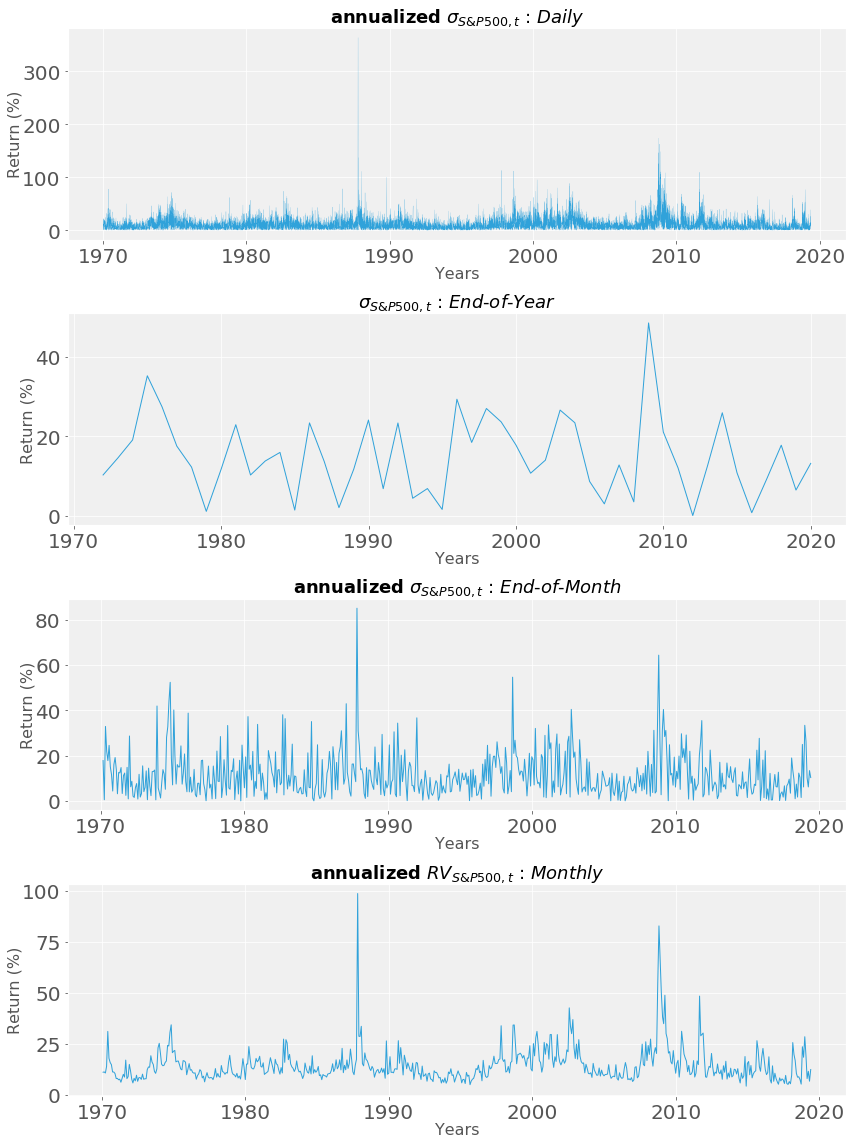

In [19]:
fig1, axes1 = plt.subplots(nrows=4, ncols=1, figsize=(12, 16))  
plt.subplots_adjust(hspace=0.5, wspace=0.5)
axes_idx = create_hist_data(stock=aret_RVol_d['S&P500'], stock_ticker=r'$\bf{annualized}$'+' $\sigma_{S&P500,t}$', 
                            freq='$Daily$', axes=axes1, lw=0.15, x=0)
axes_idx = create_hist_data(stock=aret_RVol_eoy['S&P500'], stock_ticker='$\sigma_{S&P500,t}$', 
                            freq='$End$-$of$-$Year$', axes=axes1, lw=1, x=axes_idx)
axes_idx = create_hist_data(stock=aret_RVol_eom['S&P500'], stock_ticker=r'$\bf{annualized}$'+' $\sigma_{S&P500,t}$', 
                            freq='$End$-$of$-$Month$', axes=axes1, lw=1, x=axes_idx)
axes_idx = create_hist_data(stock=aret_RVol_m['S&P500'], stock_ticker=r'$\bf{annualized}$'+' $RV_{S&P500,t}$', 
                            freq='$Monthly$', axes=axes1, lw=1, x=axes_idx)
fig1.tight_layout()

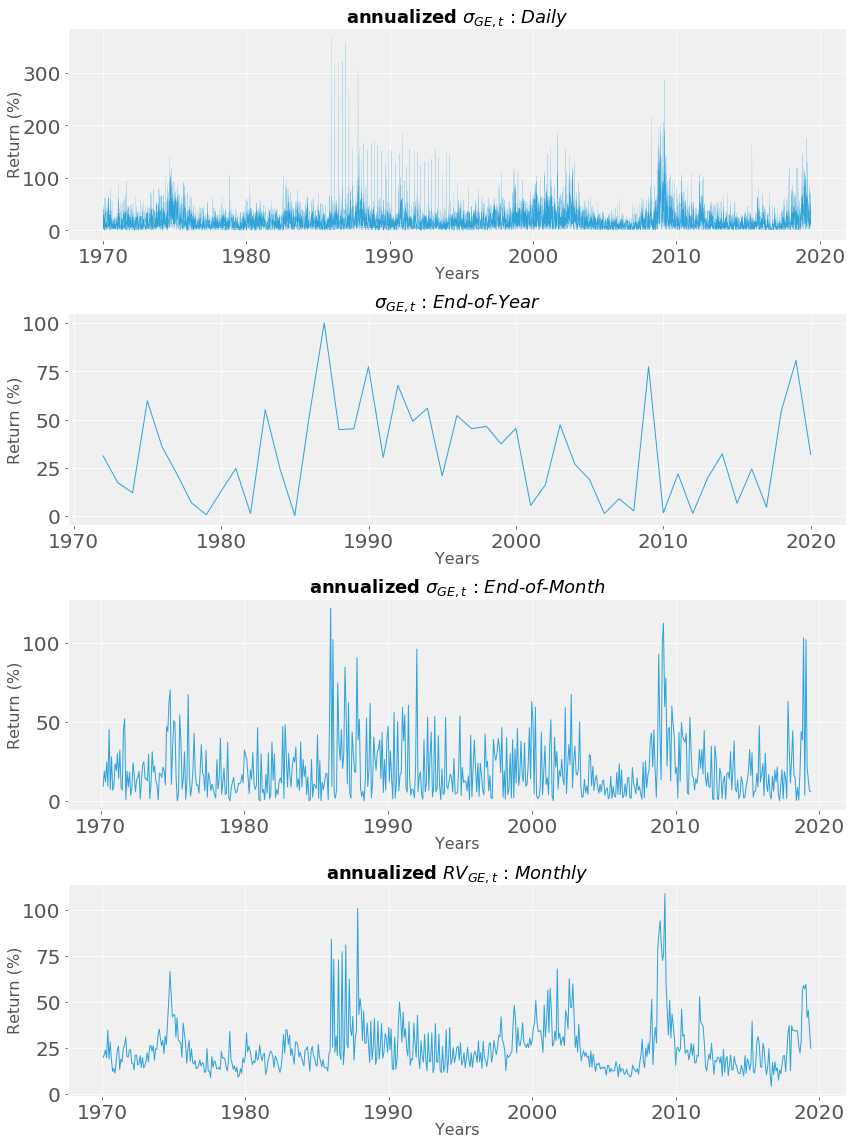

In [20]:
fig2, axes2 = plt.subplots(nrows=4, ncols=1, figsize=(12, 16))  
plt.subplots_adjust(hspace=0.5, wspace=0.5)
axes_idx = create_hist_data(stock=aret_RVol_d['GE'], stock_ticker=r'$\bf{annualized}$'+' $\sigma_{GE,t}$', 
                            freq='$Daily$', axes=axes2, lw=0.15, x=0)
axes_idx = create_hist_data(stock=aret_RVol_eoy['GE'], stock_ticker='$\sigma_{GE,t}$', 
                            freq='$End$-$of$-$Year$', axes=axes2, lw=1, x=axes_idx)
axes_idx = create_hist_data(stock=aret_RVol_eom['GE'], stock_ticker=r'$\bf{annualized}$'+' $\sigma_{GE,t}$', 
                            freq='$End$-$of$-$Month$', axes=axes2, lw=1, x=axes_idx)
axes_idx = create_hist_data(stock=aret_RVol_m['GE'], stock_ticker=r'$\bf{annualized}$'+' $RV_{GE,t}$', 
                            freq='$Monthly$', axes=axes2, lw=1, x=axes_idx)
fig2.tight_layout()

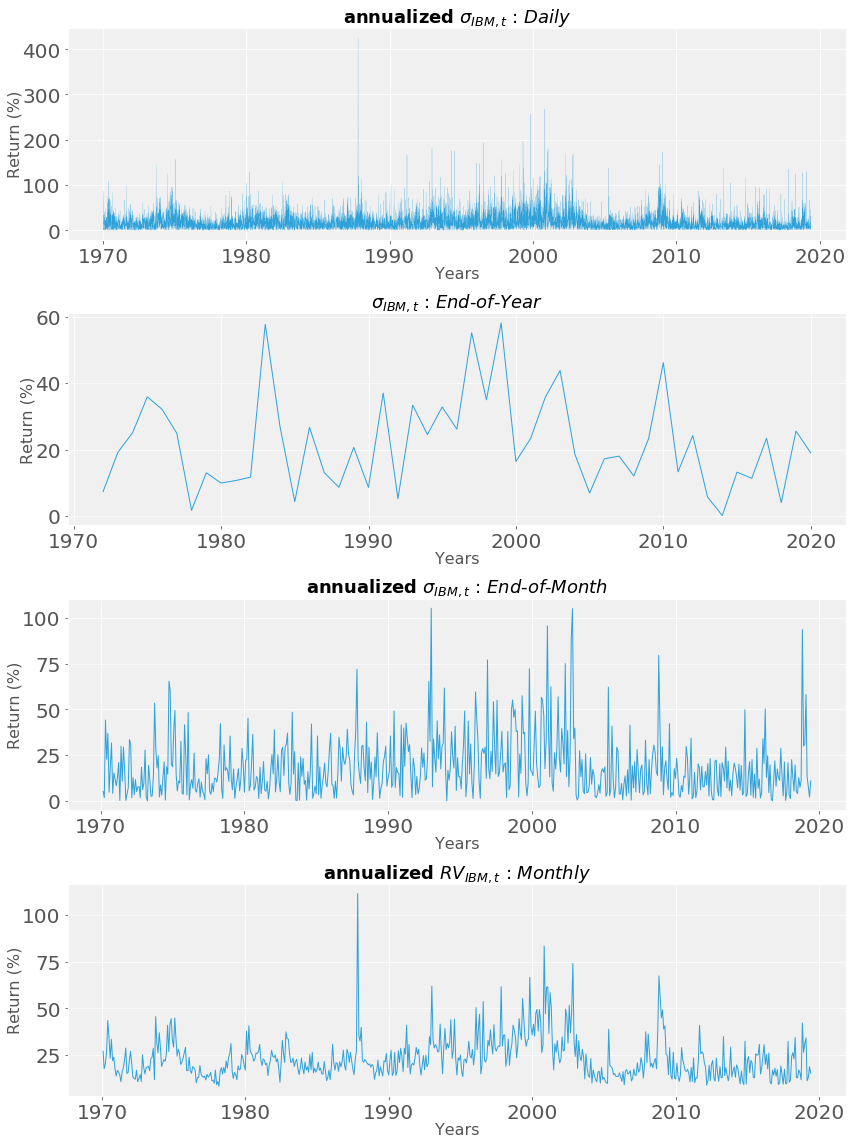

In [21]:
fig3, axes3 = plt.subplots(nrows=4, ncols=1, figsize=(12, 16))  
plt.subplots_adjust(hspace=0.5, wspace=0.5)
axes_idx = create_hist_data(stock=aret_RVol_d['IBM'], stock_ticker=r'$\bf{annualized}$'+' $\sigma_{IBM,t}$', 
                            freq='$Daily$', axes=axes3, lw=0.15, x=0)
axes_idx = create_hist_data(stock=aret_RVol_eoy['IBM'], stock_ticker='$\sigma_{IBM,t}$', 
                            freq='$End$-$of$-$Year$', axes=axes3, lw=1, x=axes_idx)
axes_idx = create_hist_data(stock=aret_RVol_eom['IBM'], stock_ticker=r'$\bf{annualized}$'+' $\sigma_{IBM,t}$', 
                            freq='$End$-$of$-$Month$', axes=axes3, lw=1, x=axes_idx)
axes_idx = create_hist_data(stock=aret_RVol_m['IBM'], stock_ticker=r'$\bf{annualized}$'+' $RV_{IBM,t}$', 
                            freq='$Monthly$', axes=axes3, lw=1, x=axes_idx)
fig3.tight_layout()

### Discussion: 

It is worth noting that **annualized realized volatility of *daily* returns** is approximately the same as the **annualized monthly volatility from daily returns**.

Moreover, the **annualized realized volatility of *monthly* returns** is different to the **annualized monthly volatility from *daily* returns** as a result of the serial correlation from daily returns. They are only equal when return are i.i.d. (which in practice, is never the case). On average, the **annualized realized volatility of *monthly* returns** is less than **annualized monthly volatility from *daily* returns**, suggesting that on average, the autocorrelation effect is positive.


To account for autocorrelation, we consider the adjusted measure $RVol_{t}^{adj}$:

$$
\begin{align*}
  RVol_{t}^{adj} = \sqrt{\sum_{d\in t}\{r_{d,t}^2\} + \sum_{d\in t}\{r_{d,t}r_{d-1,t}\} + \sum_{d\in t}\{r_{d,t}r_{d-2,t}\} + ... +\sum_{d\in t}\{r_{d,t}r_{d-D,t}\}}
\end{align*}  
$$

where $D$ denotes the last day in month $t$. Below I construct this measure and analyze it.

In [22]:
def create_realizedVar(x):
    rvol = 0 
    for d in range(0, x.shape[0]):
        x_lagd = x.shift(d).fillna(0)
        rvol = rvol + np.sum(np.multiply(x, x_lagd))    
    rvol_m = rvol**0.5    
    return rvol_m


In [23]:
aret_RVoladj_m = (12**0.5)*ret_d.resample('M').apply(create_realizedVar)

In [24]:
aret_RVoladj_m_summ = pd.concat([aret_RVoladj_m.describe()], axis=1, keys=['AC-Adjusted $Monthly$ from $Daily$']) 
aret_RVoladj_m_summ.loc['count'] = aret_RVoladj_m_summ.loc['count'].apply('{:.0f}'.format)


Just looking at the **time-series average**:

In [25]:
multi_table([aret_RVol_eom_summ.loc[['mean']], aret_RVol_m_summ.loc[['mean']], aret_RVoladj_m_summ.loc[['mean']] ])

As an example, for the **S&P500 Index**, we compare all 3 *monthly* volatility measures.:

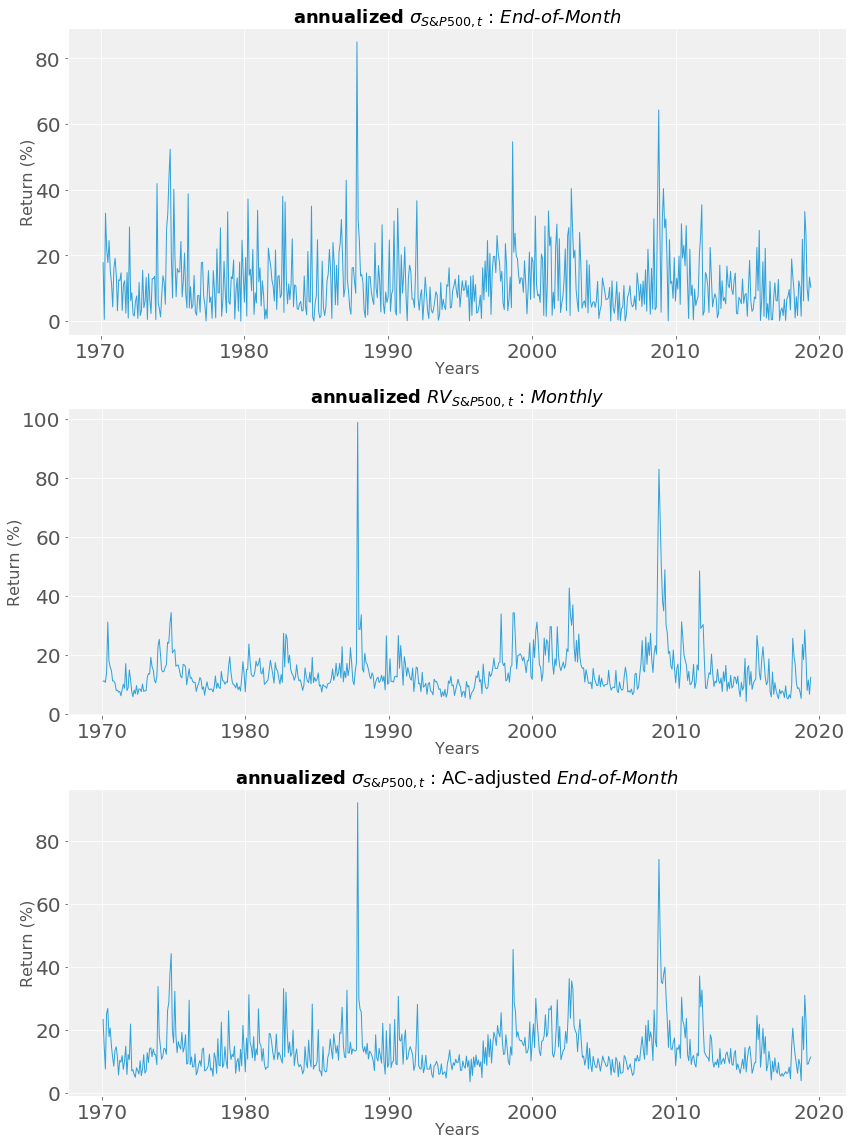

In [26]:
fig4, axes4 = plt.subplots(nrows=3, ncols=1, figsize=(12, 16))  
plt.subplots_adjust(hspace=0.5, wspace=0.5)
axes_idx = create_hist_data(stock=aret_RVol_eom['S&P500'], stock_ticker=r'$\bf{annualized}$'+' $\sigma_{S&P500,t}$', 
                            freq='$End$-$of$-$Month$', axes=axes4, lw=1, x=0)
axes_idx = create_hist_data(stock=aret_RVol_m['S&P500'], stock_ticker=r'$\bf{annualized}$'+' $RV_{S&P500,t}$', 
                            freq='$Monthly$', axes=axes4, lw=1, x=axes_idx)
axes_idx = create_hist_data(stock=aret_RVoladj_m['S&P500'], stock_ticker=r'$\bf{annualized}$'+' $\sigma_{S&P500,t}$', 
                            freq='AC-adjusted $End$-$of$-$Month$', axes=axes4, lw=1, x=axes_idx)

fig4.tight_layout()

## Exercise 1 (Part B & C): 

Estimate an AR($1$) model for realized monthly volatility. What features of the data and model are noteworthy?

Using the AR($1$) model, compute one-month-ahead forecasts of the realized volatility.  

Plot realized volatility and forecasted realized volatility.  (For simplicity, us the forecasts from the in-sample AR(1) regression instead of true out-of-sample forecasts.)

### Solution to Exercise 1 (Part B & C): 

To estimate an AR($1$) model for realized monthly volatility $\sigma_t:=RVol_{t}$, we can use **OLS**. The AR($1$) model is given by:

$$
\begin{align*}
\sigma_t &= \omega + \beta ~\sigma_{t-1} + \epsilon_{t}\\
    \epsilon_{t} &\overset{i.i.d.}{\sim}WN(0,\sigma_{\epsilon}^2)
\end{align*}
$$

We will make use of the `statsmodels` OLS "wrapper" used in previous labs and extend it so we can plot realized volatility $ \sigma_{t+h}$ and $h$-period ahead forecasts of realized volatility, $E_t\left[ \sigma_{t+h} \right]$, either in-sample or out-of-sample. 

In anticipation of **Question 1, Part D**, the user-defined "wrapper" will also compute the following model evaluation metrics:

1. **Mean Squared Error (MSE)**: 
$$
\begin{align*}
    \frac{1}{T} \sum_{t=1}^{T} \left( \sigma_{t+h}  -  \sigma_{t+h|t} \right)^2
\end{align*}
$$

2. **Root Mean Squared Error (RMSE)**: 
$$
\begin{align*}
    \sqrt{\frac{1}{T} \sum_{t=1}^{T} \left(\sigma_{t+h} - \sigma_{t+h|t}\right)^2}
\end{align*}
$$

3. **Mean Absolute Error (MAE)**: 
$$
\begin{align*}
    \frac{1}{T} \sum_{t=1}^{T} \left|\sigma_{t+h} - \sigma_{t+h|t}\right|
\end{align*}
$$

where $\sigma_{t+h|t}$ $\left(\text{or }E_t\left[\sigma_{t+h} \right]\right)$ denotes the forecast of $\sigma_{t+h}$ given all information at time $t$. For general $h$-step ahead forecasts implied by an AR($1$) model (in-sample or out-of-sample), we can use the formula:

$$
\begin{align*}
    \sigma_{t+h|t} = \omega\left(1 + \beta + \beta^2 +...+ \beta^{h-1}\right) + \beta^h \sigma_{t}
\end{align*}
$$

**Note:** One issue with using an OLS regression to forecast realized volatility $\sigma_t:=RVol_{t}$ is the fact we don't restrict the forecasts to be <u>positive</u>, which we know must be positive by definition (and in practice). 

In [27]:
### "wrapped" OLS 'statsmodel' routine for AR(1) realized volatility estimation and prediction evaluation
def _sm_ar1_ols_eval(rvTrain, rvTest, max_horizon=1, addcon=True, cov_type=None, 
                     plot_rvTest=True, summary=True, annualize=False, freq=None):
    """
    Wrapper for statsmodels OLS estimation of AR(1) Realized volatilty model
    PARAM: "rvTrain" is 'DataFrame' with training/estimation sample for realized volatility
    PARAM: "rvTest" is 'DataFrame' with testing/forecasting sample used in out-of-sample forecasting. 
            If "rvTrain"=="rvTest", then forecasting is in terms of in-sample fit.
    PARAM: "max_horizon" is the maximum horizon of the h-step ahead forecasts [default: max_horizon=1]  
    PARAM: "plot_rvTest" is 'bool'=True if plotting the "rvTest" and its max_horizon-step ahead forecast 
            (in-sample or oos), =False, otherwise [default: plot_rvTest=True] 
    PARAM: "summary" is bool='True' if displaying OLS summary of result, =False otherwise [default: summary=True] 
    PARAM: "annualize" is bool='True' is annualizing volatility measures, =False otherwise [default: annualize=True] 
    PARAM: "freq" is 'str' with frequency of the time-series (daily:'D', monthly:'M')
    """
    l1_rvTrain = rvTrain.shift() 
    if addcon:
        L1_rvTrain = sm.add_constant(l1_rvTrain)
    else:
        L1_rvTrain = l1_rvTrain
    
    if cov_type==None:
        se_type = 'OLS'
        ols_results = sm.OLS(rvTrain, L1_rvTrain, missing='drop').fit()
    elif 'HC' in cov_type:
        se_type = 'White'
        ols_results = sm.OLS(rvTrain, L1_rvTrain, missing='drop').fit(cov_type=cov_type)
    elif 'HAC'in cov_type: 
        nw_maxlags = 4
        se_type = 'NW('+str(nw_maxlags)+')'
        ols_results = sm.OLS(rvTrain, L1_rvTrain, missing='drop').fit(cov_type='HAC', maxlag=nw_maxlags)
     
    ### print out the OLS estimation results
    if summary:
        print('**** '+rvTrain.name+' ****\n\n', 
              ols_results.summary(yname='RVol-'+rvTrain.name, xname=['omega_{'+rvTrain.name+'}', 'beta_{'+rvTrain.name+'}']))  
    
    omega = ols_results.params[0]
    beta  = ols_results.params[1:].item()
    ols_resids = ols_results.resid  # resids
    
    rv_forecasts_h = pd.DataFrame(index=rvTest.index, columns=list(range(1, max_horizon)))
    MSE, RMSE, MAE = {}, {}, {}  
    for h in range(1, max_horizon+1):
        rep_omega = omega*np.ones(h)
        beta_h = np.array([(beta**k) for k in range(0, h)])
        rv_forecasts_h[h] = (np.dot(rep_omega, beta_h.T) + (beta**h)*rvTest.shift(h))

        ### MSE, RMSE, & MAE        
        error_h = (rvTest - rv_forecasts_h[h]).dropna()
        T_h = len(error_h) 
        MSE[h] = (1/T_h)*np.sum(error_h**2)
        RMSE[h] = ((1/T_h)*np.sum(error_h**2))**0.5
        MAE[h] = (1/T_h)*np.sum(np.abs(error_h))  
    
    ols_output = {'ols_results': ols_results,
                  'se_type': se_type,
                  'omega': omega, 
                  'beta': beta, 
                  'omega_se': ols_results.bse[0], 
                  'beta_se': ols_results.bse[1:].item(),
                  'omega_tstat': ols_results.tvalues[0], 
                  'beta_tstat': ols_results.tvalues[1:].item(),                 
                  'resids': ols_resids, 
                  'max_forecast_h': max_horizon,
                  'rv_forecasts_h': rv_forecasts_h,
                  'BIC':ols_results.bic, 'MSE': MSE, 'RMSE': RMSE, 'MAE': MAE} 
    
    if annualize:
        a_label = '$\\bf{annualized}$'
        if freq=='D':
            scale = 252**0.5
        elif freq=='M':
            scale = 12**0.5
    else: 
        a_label = ''
        scale = 1
    
    if plot_rvTest:
        fig, axes = plt.subplots(figsize=(11,8))
        axes.plot(scale*rvTrain, lw=1.5, label='Training: $\sigma_{t+h}$')
        axes.plot(scale*rvTest,  lw=1.5, label='Testing: $\sigma_{t+h}$')
        axes.plot(scale*rv_forecasts_h[1], lw=1.5, label='$E_t[\sigma_{t+h}]=\sigma_{t+h|t}$')
        axes.set_xlabel('Years', fontsize=18)
        axes.set_ylabel('Return (%)', fontsize=18)
        title_label = 'log '+rvTest.name+' returns:\n'+a_label+'\nRealized Vol $(\sigma_{t+h})$,'+\
                      '\n$Forecasted$ $(h='+str(1)+')$ Realized Vol $(\sigma_{t+h|t})$'      
        axes.set_title(title_label, fontsize=18)
        axes.legend(fontsize=18)   
        fig.tight_layout()
    
    return ols_output

For in-sample forecasts, the training and testing samples will be identical. 

/Users/chris.jauregui/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


**** S&P500 ****

                             OLS Regression Results                            
Dep. Variable:            RVol-S&P500   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     46.26
Date:                Sat, 18 May 2019   Prob (F-statistic):           2.54e-11
Time:                        19:54:59   Log-Likelihood:                -1219.4
No. Observations:                 592   AIC:                             2443.
Df Residuals:                     590   BIC:                             2452.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
omega_{S&P500}     1.5756

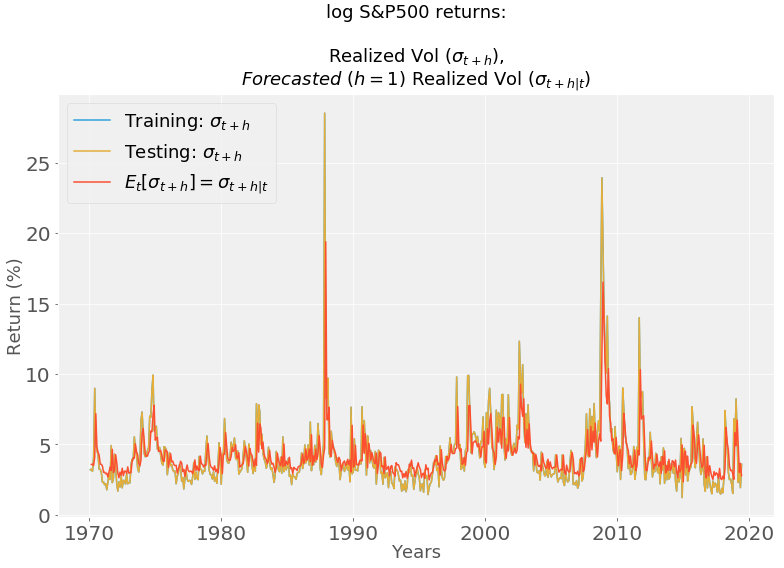

In [28]:
rv_m = RVol_m['S&P500']
ar1_SP500_output = _sm_ar1_ols_eval(rvTrain=rv_m, rvTest=rv_m, max_horizon=5, addcon=True, cov_type='HC0')


**** GE ****

                             OLS Regression Results                            
Dep. Variable:                RVol-GE   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     91.84
Date:                Sat, 18 May 2019   Prob (F-statistic):           2.58e-20
Time:                        19:55:00   Log-Likelihood:                -1547.4
No. Observations:                 592   AIC:                             3099.
Df Residuals:                     590   BIC:                             3108.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
omega_{GE}     3.1893      0.386     

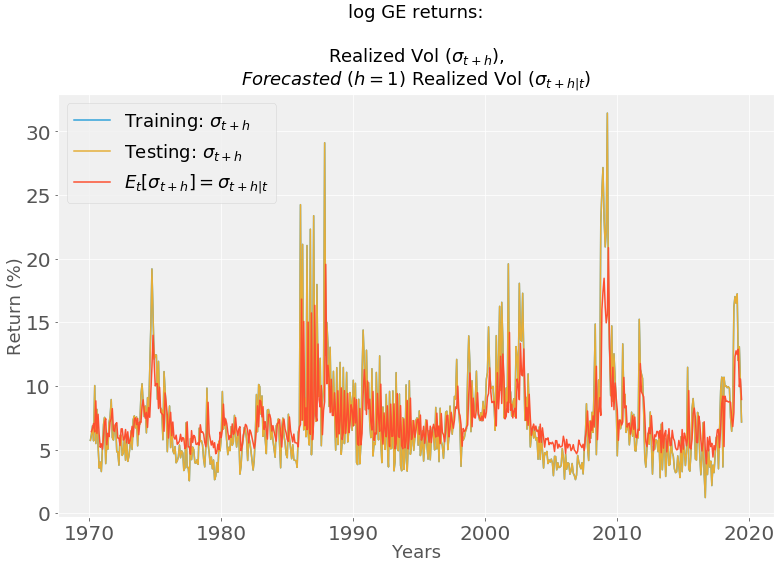

In [29]:
rv_m = RVol_m['GE']
ar1_GE_output =  _sm_ar1_ols_eval(rvTrain=rv_m, rvTest=rv_m, max_horizon=5, addcon=True, cov_type='HC0')


**** IBM ****

                             OLS Regression Results                            
Dep. Variable:               RVol-IBM   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     92.44
Date:                Sat, 18 May 2019   Prob (F-statistic):           1.98e-20
Time:                        19:55:00   Log-Likelihood:                -1444.4
No. Observations:                 592   AIC:                             2893.
Df Residuals:                     590   BIC:                             2902.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
omega_{IBM}     3.1735      0.340 

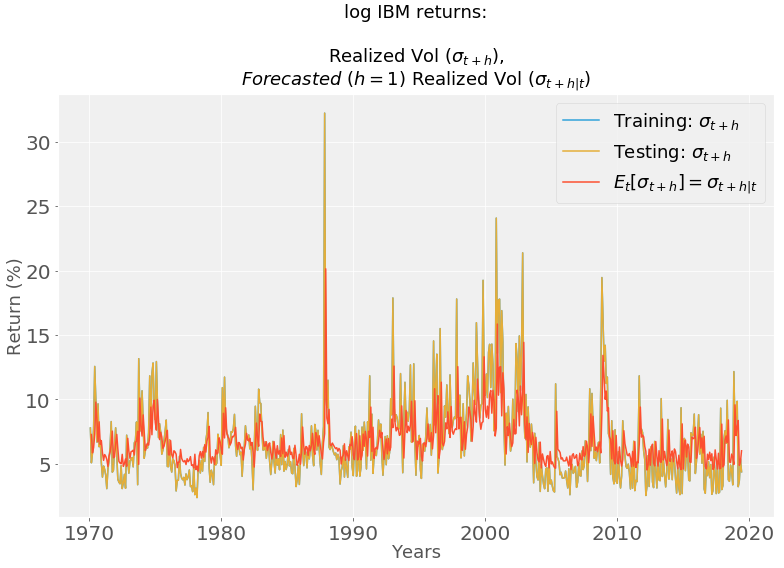

In [30]:
rv_m = RVol_m['IBM']
ar1_IBM_output =  _sm_ar1_ols_eval(rvTrain=rv_m, rvTest=rv_m, max_horizon=5, addcon=True, cov_type='HC0')


We can put together all of our results into one table:

In [31]:
row_midx = pd.MultiIndex.from_product([list(RVol_m.columns), ['$\widehat{\omega}$', '$\widehat{\\beta}$']], 
                                      names=['ticker', 'param'])
se_type = '$White$'
ar1_est_table = pd.DataFrame(index=row_midx, columns=['estimate', '$SE$(estimate)_'+se_type, '$t$(estimate)_'+se_type])
for ticker in RVol_m.columns:
    df_ticker_name = 'ar1_' + ticker.replace('&','') + '_output'  
    ar1_est_table.loc[ticker, '$\widehat{\omega}$'] = [locals()[df_ticker_name]['omega'], locals()[df_ticker_name]['omega_se'], 
                                                       locals()[df_ticker_name]['omega_tstat']] 
    ar1_est_table.loc[ticker, '$\widehat{\\beta}$'] = [locals()[df_ticker_name]['beta'], locals()[df_ticker_name]['beta_se'], 
                                                       locals()[df_ticker_name]['beta_tstat']]  
    

In [32]:
display(ar1_est_table)

estimate $SE$(estimate)_$White$  \
ticker param                                                
S&P500 $\widehat{\omega}$    1.576                  0.359   
       $\widehat{\beta}$     0.625                  0.092   
GE     $\widehat{\omega}$    3.189                  0.386   
       $\widehat{\beta}$     0.562                  0.059   
IBM    $\widehat{\omega}$    3.173                  0.340   
       $\widehat{\beta}$     0.526                  0.055   

                          $t$(estimate)_$White$  
ticker param                                     
S&P500 $\widehat{\omega}$                 4.393  
       $\widehat{\beta}$                  6.802  
GE     $\widehat{\omega}$                 8.254  
       $\widehat{\beta}$                  9.583  
IBM    $\widehat{\omega}$                 9.336  
       $\widehat{\beta}$                  9.615

Recall the persistence of volatility in GARCH models is sum of the ARCH and GARCH parameters (which have magnitudes of about 0.2 and 0.8, respectively). The persistence is very high in GARCH models: close to non-stationary. 

Here, in the $AR$ estimation, realized volatility is not very persistent. This is not surprising since AR($1$) dynamics are not complicated. 

**Question:** If we simulated a non-stationary GARCH($1$, $1$) process and then estimated an AR($1$) model on the GARCH($1$, $1$)-implied volatility process, what would we get?

### Discussion 1:

A notable feature of the results shown above is the magnitudes of the AR($1$) coefficient estimates $\widehat{\beta}$, which are somewhat small, especially for **GE** and **IBM**. These coefficients are substantially different from a value of 1. 

Moreover, the AR($1$) forecasts are systematically off. Specifically, we see that on average, they over-predict realized volatility $RVol_t$. Why is that? 
**Answer:** There are many reasons:
1. Zero is a "reflecting barrier" for $RVol_t$, hence as $RVol_t$ gets closer to zero, the forecasts will have to systematically higher since you can only move up from zero. 
   The AR($1$) model does not restrict the forecast to be positive, hence consistently off. In-sample forecasts will be ok, but out-of-sample may be problematic. 
2. The large spikes in the realized volatility process are also problematic. 

A solution is to estimate an AR($1$) model and obtain forecasts using log($RVol_t$). Summarizing, forecasts for an underlying process with "reflecting barriers" will be significantly biased around the "barriers". Away from the "barriers", they will be better behaved. 

**Note:** For a realized volatility process that is very high (i.e. few realizations close to zero), the AR($1$) model is much better. 

### Discussion 2:

If we regressed an individual firm's realized volatility (e.g GE's) on the **S&P500 Index** realized volatility, then the slope coefficient on the **S&P500 Index** realized volatility could be interpreted as a "volatility beta" and allows us to ask the following : When **market volatility** increases (decreases), how much does **GE's volatility** increase (decrease)?

The $R^2$ of such regressions tells us to what degree GE's total volatility is captured by the market and what is firm-specific:
   * Intuitively, a <u>large</u> firm should have a LARGER  $R^2$ in a regression of this type in comparison to a <u>small</u> firm.
   * This additional analysis is difficult to conduct with ARCH/GARCH models. 
       * Much simpler using an OLS regression framework, albeit not completely robust and rigorous (it's quick and easy).
       
To hedge volatility of an individual firm's stock, the $R^2$ is very informative: we can write down **linear factor models** for volatility as well:
   * A high $R^2$ means an individual firm's stock volatility can be significantly hedged with market volatility.
   * In practice hedging volatility involves more complicated modeling, beyond a regression framework. 

## Exercise 1 (Part D): 

Compute the **Mean-Square-Error (RMSE)** of the AR($1$)-implied $h$-step ahead forecasts 
$$
E\left[ \left( \sigma _{t+1}-\hat{\sigma}_{t+1|t}\right] ^{2}\right) 
$$

(as well as the **MSE** and **MAE**, which were described earlier)

In [33]:
max_horizon = max(ar1_SP500_output['max_forecast_h'], ar1_GE_output['max_forecast_h'], ar1_IBM_output['max_forecast_h'])
row_midx = pd.MultiIndex.from_product([list(range(1, max_horizon+1)), ['MSE', 'RMSE', 'MAE']], names=['h-step', 'metric'])

ar1_model_eval = pd.DataFrame(index=row_midx, columns=RVol_m.columns)
for h in range(1, max_horizon+1):
    ar1_model_eval.loc[h, ['S&P500']] = np.array([ar1_SP500_output[x][h] for x in ['MSE', 'RMSE', 'MAE']])
    ar1_model_eval.loc[h, ['GE']] = np.array([ar1_GE_output[x][h] for x in ['MSE', 'RMSE', 'MAE']])
    ar1_model_eval.loc[h, ['IBM']] = np.array([ar1_IBM_output[x][h] for x in ['MSE', 'RMSE', 'MAE']])

ar1_model_eval = pd.concat([ar1_model_eval], axis=1, keys=['$AR(1)$'])   

### Solution to Exercise 1 (Part D): 

In [34]:
display(ar1_model_eval)

$AR(1)$              
               S&P500     GE    IBM
h-step metric                      
1      MSE      3.603 10.912  7.705
       RMSE     1.898  3.303  2.776
       MAE      1.097  2.199  1.883
2      MSE      4.506 12.172  8.831
       RMSE     2.123  3.489  2.972
       MAE      1.282  2.394  2.079
3      MSE      5.068 13.359  9.352
       RMSE     2.251  3.655  3.058
       MAE      1.358  2.509  2.163
4      MSE      5.529 14.886 10.190
       RMSE     2.351  3.858  3.192
       MAE      1.450  2.662  2.277
5      MSE      5.616 15.442 10.394
       RMSE     2.370  3.930  3.224
       MAE      1.476  2.728  2.309

## Exercise 1 (Addendum):

Revisit the AR($1$) model and compute AR($1$)-implied, $h$-period out-of-sample (oos) forecasts for the **S&P 500 Index**, **GE**, and **IBM**. 

Consider $h=1,2,3,4,5$ as a starting point. How do the **MSE**, **RMSE**, and **MAE** compare across $h$?

#### Note:
Work with the sample period from lecture: **1/3/1990 - 12/31/2017**
* Training/Estimation period: **1/3/1990 - 12/31/2009**
* Testing/Out-of-sample period: **1/2/2010 - 12/31/2017**


### Solution to Exercise 1 (Addendum): 

Let's use the previously-defined function `_sm_ar1_ols_eval`

**** S&P500 ****

                             OLS Regression Results                            
Dep. Variable:            RVol-S&P500   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     114.0
Date:                Sat, 18 May 2019   Prob (F-statistic):           5.47e-22
Time:                        19:55:01   Log-Likelihood:                -471.33
No. Observations:                 239   AIC:                             946.7
Df Residuals:                     237   BIC:                             953.6
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
omega_{S&P500}     0.9863

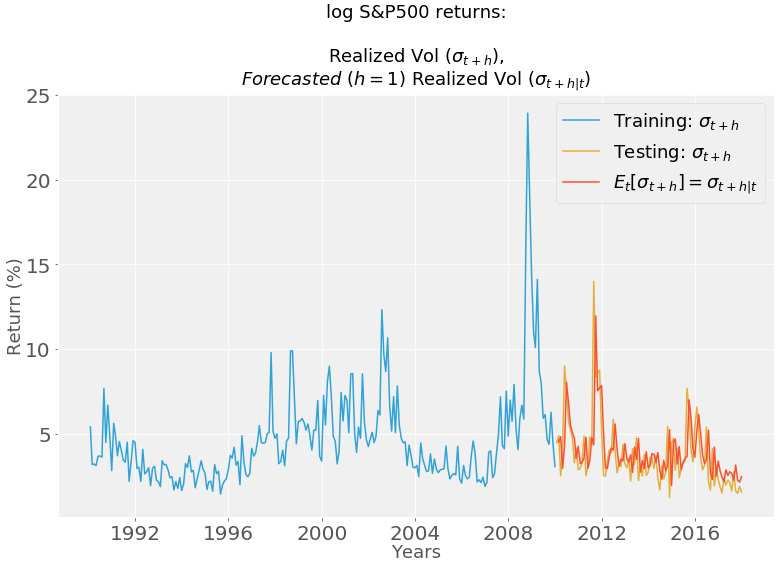

In [35]:
### S&P500
rvTrain = RVol_m.loc['1990-01-03':'2009-12-31', ['S&P500']].squeeze()
rvTest  = RVol_m.loc['2010-01-02':'2017-12-31', ['S&P500']].squeeze()
ar1_SP500_output_oos = _sm_ar1_ols_eval(rvTrain=rvTrain, rvTest=rvTest, max_horizon=5, addcon=True, cov_type='HC0')


**** GE ****

                             OLS Regression Results                            
Dep. Variable:                RVol-GE   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     84.76
Date:                Sat, 18 May 2019   Prob (F-statistic):           1.84e-17
Time:                        19:55:02   Log-Likelihood:                -618.04
No. Observations:                 239   AIC:                             1240.
Df Residuals:                     237   BIC:                             1247.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
omega_{GE}     2.4228      0.526     

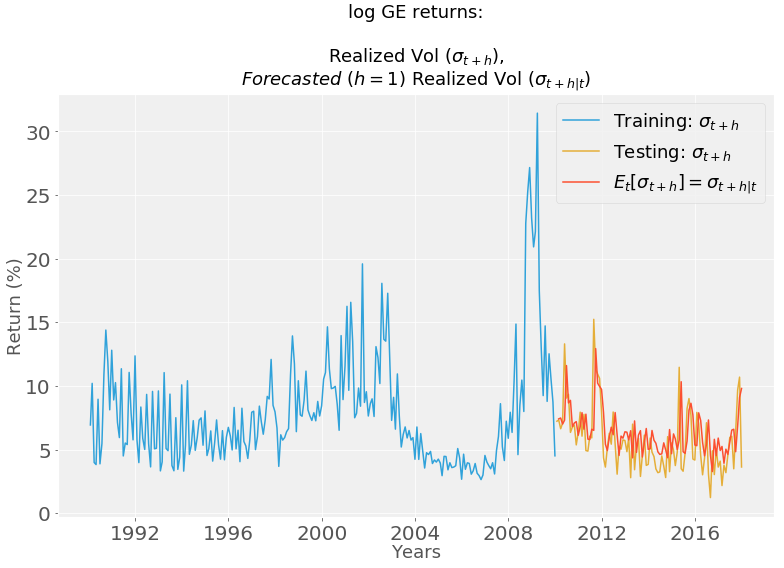

In [36]:
### GE
rvTrain = RVol_m.loc['1990-01-03':'2009-12-31', ['GE']].squeeze()
rvTest  = RVol_m.loc['2010-01-02':'2017-12-31', ['GE']].squeeze()
ar1_GE_output_oos = _sm_ar1_ols_eval(rvTrain=rvTrain, rvTest=rvTest, max_horizon=5, addcon=True, cov_type='HC0')


**** IBM ****

                             OLS Regression Results                            
Dep. Variable:               RVol-IBM   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     90.33
Date:                Sat, 18 May 2019   Prob (F-statistic):           2.35e-18
Time:                        19:55:03   Log-Likelihood:                -615.17
No. Observations:                 239   AIC:                             1234.
Df Residuals:                     237   BIC:                             1241.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
omega_{IBM}     3.6581      0.426 

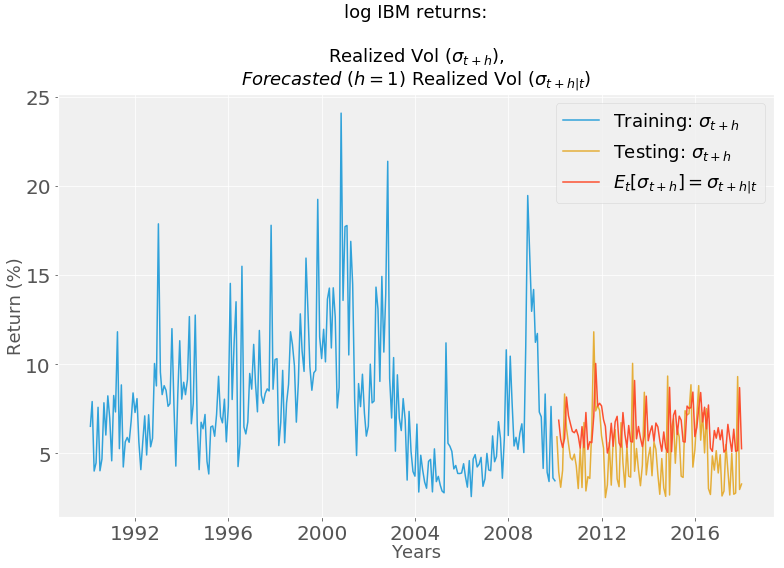

In [37]:
### IBM
rvTrain = RVol_m.loc['1990-01-03':'2009-12-31', ['IBM']].squeeze()
rvTest  = RVol_m.loc['2010-01-02':'2017-12-31', ['IBM']].squeeze()
ar1_IBM_output_oos = _sm_ar1_ols_eval(rvTrain=rvTrain, rvTest=rvTest, max_horizon=5, addcon=True, cov_type='HC0')

In [38]:
max_horizon = max(ar1_SP500_output_oos['max_forecast_h'], ar1_GE_output_oos['max_forecast_h'], 
                  ar1_IBM_output_oos['max_forecast_h'])
row_midx = pd.MultiIndex.from_product([list(range(1, max_horizon+1)), ['MSE', 'RMSE', 'MAE']], names=['h-step', 'metric'])

ar1_model_eval_oos = pd.DataFrame(index=row_midx, columns=RVol_m.columns)
for h in range(1, max_horizon+1):
    ar1_model_eval_oos.loc[h, ['S&P500']] = np.array([ar1_SP500_output_oos[x][h] for x in ['MSE', 'RMSE', 'MAE']])
    ar1_model_eval_oos.loc[h, ['GE']] = np.array([ar1_GE_output_oos[x][h] for x in ['MSE', 'RMSE', 'MAE']])
    ar1_model_eval_oos.loc[h, ['IBM']] = np.array([ar1_IBM_output_oos[x][h] for x in ['MSE', 'RMSE', 'MAE']])

ar1_model_eval_oos = pd.concat([ar1_model_eval_oos], axis=1, keys=['$AR(1)$'])        

In [39]:
display(ar1_model_eval_oos)

$AR(1)$             
               S&P500    GE    IBM
h-step metric                     
1      MSE      3.149 5.699  6.375
       RMSE     1.775 2.387  2.525
       MAE      1.238 1.774  2.096
2      MSE      3.722 7.223  8.321
       RMSE     1.929 2.688  2.885
       MAE      1.404 2.134  2.546
3      MSE      4.004 8.028  9.578
       RMSE     2.001 2.833  3.095
       MAE      1.485 2.392  2.753
4      MSE      4.545 8.700 10.849
       RMSE     2.132 2.950  3.294
       MAE      1.633 2.575  2.925
5      MSE      4.248 9.052 11.504
       RMSE     2.061 3.009  3.392
       MAE      1.615 2.649  3.036

#### Discussion:

For the out-of-sample forecasts, we see the **RMSE** for all three equity returns approximately increases and then decreases. Intuitively, we get this because of the mean-reversion implied by the $AR(1$) model. 

# Exercise 2 : 

Estimate a GARCH($1$,$1$) model for monthly returns. What features of the data and model are noteworthy?

Regress realized monthly volatility on GARCH($1$,$1$) conditional volatility. Plot realized volatility and conditional volatility.

## Solution to Exercise 2: 

A GARCH($1$, $1$) model for realized monthly volatility is given by:

$$
\begin{align*}
r_{t} &= \mu + \phi r_{t-1} + \sigma_{t}e_{t} \\
\sigma_{t}^2 &= \omega + \alpha \epsilon_{t-1}^2 +  \beta \sigma_{t-1}^2 \\
e_{t} & \overset{i.i.d.}{\sim} N(0,1)
\end{align*}
$$

where as noted earlier and in lecture, $\sigma_{t}^2$ is known at time $t-1$ (i.e. it is deterministic). Also, $\sigma_{t}$ and $e_{t}$ are statistically independent. 

Using the `arch` package, which among many things, provides estimation routines for univariate volatility models (see [online documentation](https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_modeling.html)). The model constructor is given by `arch.arch_model` with a GARCH($1$, $1$) model being the default constructor.



To estimate a general GARCH($p$, $q$) model we need to pass additional arguments. 
Specifically, we need to pass: 
* name of the mean model: `mean` 
* lag length: `lags`
* name of the volatility model: `vol`
* lag order of the symmetric innovation: `p`
* lag order of lagged volatility: `q`. 

There are additional arguments we can pass, such as lag order of the asymmetric innovation, which is zero here (`o=0`), as well as the name of the error $e_t$ distribution, which is assumed to be Normal (`dist`=`Normal`). Since the defaults in place are in accordance with our model assumptions, we are not required to pass these arguments. Also, we can display the likelihood estimation convergence information (set `disp` to `on` or `off` in subroutine `summary()` after `fit()` has been executed).

#### Forecasting:
The `arch` package provides a rich set of forecasting tools (see [online documentation](https://arch.readthedocs.io/en/latest/univariate/forecasting.html)). There are three types of forecasts:
1. **Analytical**: analytical forecasts are always available for the 1-step ahead forecast due to the structure of ARCH-type models. Multi-step analytical forecasts are only available for model which are linear in the square of the residual, such as GARCH or HARCH.
2. **Simulation-based**: simulation-based forecasts are always available for any horizon, although they are only useful for horizons larger than 1 since the first out-of-sample forecast from an ARCH-type model is always fixed. Simulation-based forecasts make use fo the structure of an ARCH-type model to forward simulate using the assumed distribution of residuals, e.g., a Normal or Student’s $t$.
3. **Bootstrapped**: bootstrap-based forecasts are similar to simulation based forecasts except that they make use of the standardized residuals from the actual data used in the estimation rather than assuming a specific distribution. Like simulation-base forecasts, bootstrap-based forecasts are only useful for horizons larger than 1. Additionally, the bootstrap forecasting method requires a minimal amount of in-sample data to use prior to producing the forecasts.

Given the relative simplicity of the models we will analyze, we can use Analytical forecasts. 


We can write a "wrapper" that constructs a general model instance, displays plots the volatility and standardized residuals, stores parameters, runs forecasts, etc. As in the **Exercise 1** solutions, I include compute the same model evaluation metrics for in-sample predictions.

In [40]:
def _arch_model_est(y, y_RV, ARCHModel_dict, max_horizon, train_enddt=None, test_startdt=None, 
                    summarize=True, plot_vol_measures=True, model_name='', annualize=True):
    """
    PARAM: "y" is 'DataFrame' with observed process for full sample
    PARAM: "y_RV" is the observed realized volatility of the observed process for the full sample.
    PARAM: "ARCHModel_dict" is a 'dict' with parameter values for arguments used to construct a model instance and 
           other estimation arguments
    PARAM: "train_enddt" is 'datetime' with date of last observation used in training/estimation sample
    PARAM: "test_startdt" is 'datetime' with date of first observation (exclusively) used in testing/forecasting sample
    PARAM: "summarize" is a 'bool'=True if we want to display estimation summary, ='False' otherwise 
           [default: summarize='True']
    PARAM: "plot_vol_measures" is a 'bool'=True if we want to plot the following:
            1. estimated conditional volatility, 
            2. 1-step ahead forecasted conditional volatility
            3. realized volatility
            ='False' otherwise [default: plot_vol_measures=True]
           [default: plot_condvol='True'] 
    PARAM: "annualize" is a 'bool'=True if volatility measures (observed or estimated) are annualized, ='False' otherwise
           [default: plot_condvol='True'] 
    """
    ### Training sample    
    am = arch_model(y, mean=ARCHModel_dict['mean'], lags=ARCHModel_dict['lags'], vol=ARCHModel_dict['vol'], 
                       p=ARCHModel_dict['p'], o=ARCHModel_dict['o'], q=ARCHModel_dict['q'], 
                       dist=ARCHModel_dict['dist'])

    if train_enddt==None:                    
        am_est = am.fit(disp=ARCHModel_dict['disp'])
    else:
        am_est = am.fit(disp=ARCHModel_dict['disp'], last_obs=train_enddt)

    am_dict = ARCHModel_dict.copy()
    am_dict['bic'] = am_est.bic 
    am_dict['log-likelihood'] = am_est.loglikelihood
    am_dict['params'] = am_est.params
    am_dict['cond_vol'] = am_est.conditional_volatility

    if summarize:
        print('\n**** '+y.name+' ****\n\n', am_est.summary(), 'n')   

    ### h-step ahead forecasts
    if test_startdt==None:    
        am_rv_forecasts_h = (am_est.forecast(horizon=max_horizon, align='target', method='simulation', simulations=100).variance)**0.5
    else:    
        am_rv_forecasts_h = (am_est.forecast(horizon=max_horizon, align='target', start=test_startdt).variance)**0.5           
    
    ### MSE, RMSE, & MAE     
    MSE, RMSE, MAE = {}, {}, {}  
    for h in range(1, max_horizon+1):    
        error_h = (y[test_startdt] - am_rv_forecasts_h['h.'+str(h)]).dropna()
        T_h = len(error_h) 
        MSE[h] = (1/T_h)*np.sum(error_h**2)
        RMSE[h] = ((1/T_h)*np.sum(error_h**2))**0.5
        MAE[h] = (1/T_h)*np.sum(np.abs(error_h)) 
        
    am_dict['max_forecast_h'] = max_horizon
    am_dict['rv_forecasts_h'] = am_rv_forecasts_h
    am_dict['MSE'] = MSE
    am_dict['RMSE'] = RMSE
    am_dict['MAE'] = MAE
                    
    if annualize:
        a_label = '$\\bf{annualized}$'
        if ARCHModel_dict['freq']=='D':
            scale = 252**0.5
        elif ARCHModel_dict['freq']=='M':
            scale = 12**0.5
    else:
        a_label = '$\\bf{annualized}$'
        scale = 1
                
    if plot_vol_measures:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,8))     
        axes.plot(scale*y_RV, lw=0.75, label='$RV_{t} =\sigma_{t+1}$')
        axes.plot(scale*am_est.conditional_volatility, lw=1.5, label='$'+model_name+'$: $\widehat{\sigma}_{t+1}$')
        axes.plot(scale*am_rv_forecasts_h['h.1'], lw=1.5, ls='--', color='red', 
                  label='$'+model_name+'$: $E_t[\widehat{\sigma}_{t+1|t}]$')
        axes.set_xlabel('Years', fontsize=18)
        axes.set_ylabel('Return (%)', fontsize=18)
        title_label = 'log '+y.name+' returns:\n'+a_label+'\nRealized Vol $(\sigma_{t+1})$,' +\
                      '\nEstimated Conditional Vol $(\widehat{\sigma}_{t+1})$'+\
                      '\n$Forecasted$ $(h='+str(1)+')$ Realized Vol $(\sigma_{t+h|t})$' 
        axes.set_title(title_label, fontsize=18)
        axes.legend(fontsize=16, loc='best')   
        fig.tight_layout()         
        
    return am_dict


In [41]:
garch11_dict = {'mean': 'Constant', 'lags': 0, 'vol': 'GARCH', 'p': 1, 'o': 0, 'q': 1, 'dist': 'Normal', 
                'freq': 'M', 'disp': 'off'}



**** S&P500 ****

                      Constant Mean - GARCH Model Results                      
Dep. Variable:                 S&P500   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -1687.41
Distribution:                  Normal   AIC:                           3382.82
Method:            Maximum Likelihood   BIC:                           3400.35
                                        No. Observations:                  592
Date:                Sat, May 18 2019   Df Residuals:                      588
Time:                        19:55:04   Df Model:                            4
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.6581      0.171      3.845  1.206

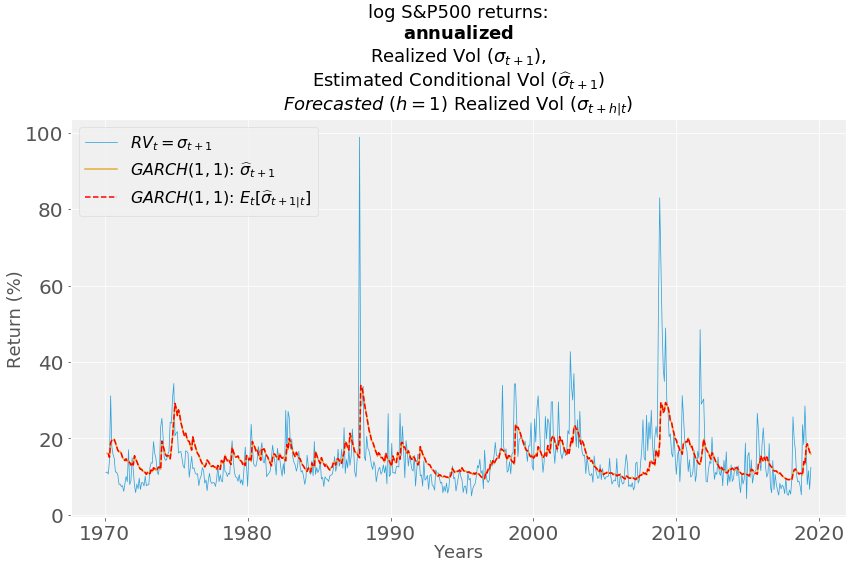

In [42]:
train_enddt = None
test_startdt = ret_eom['S&P500'].index.min()

garch11_SP500_dict =_arch_model_est(y=ret_eom['S&P500'], y_RV=RVol_m['S&P500'], ARCHModel_dict=garch11_dict, 
                                    max_horizon=5, test_startdt=test_startdt, model_name='GARCH(1,1)')


**** GE ****

                      Constant Mean - GARCH Model Results                      
Dep. Variable:                     GE   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -2014.71
Distribution:                  Normal   AIC:                           4037.43
Method:            Maximum Likelihood   BIC:                           4054.96
                                        No. Observations:                  592
Date:                Sat, May 18 2019   Df Residuals:                      588
Time:                        19:55:05   Df Model:                            4
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.4922      0.278      5.365  8.101e-08

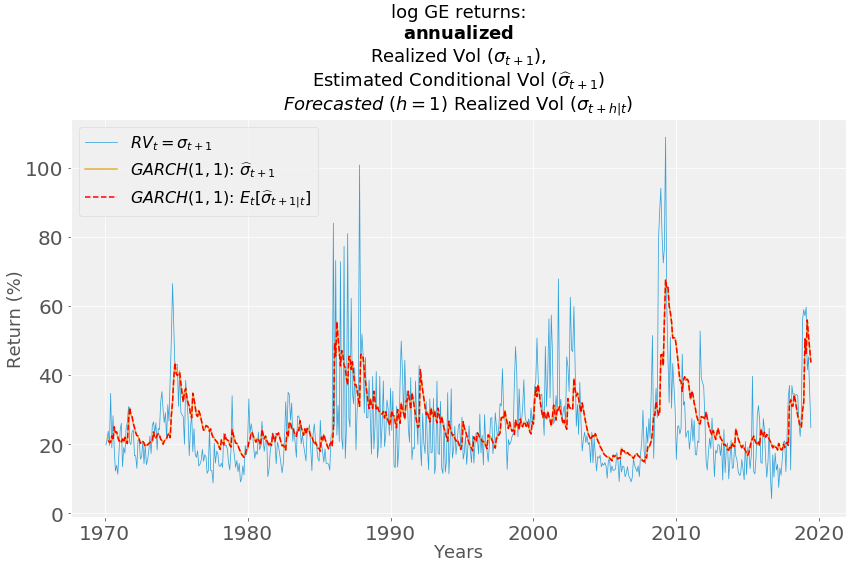

In [43]:
train_enddt = None
test_startdt = ret_eom['GE'].index.min()

garch11_GE_dict =_arch_model_est(y=ret_eom['GE'], y_RV=RVol_m['GE'], ARCHModel_dict=garch11_dict, 
                                 max_horizon=5, test_startdt=test_startdt, model_name='GARCH(1,1)')


**** IBM ****

                      Constant Mean - GARCH Model Results                      
Dep. Variable:                    IBM   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -1977.39
Distribution:                  Normal   AIC:                           3962.79
Method:            Maximum Likelihood   BIC:                           3980.32
                                        No. Observations:                  592
Date:                Sat, May 18 2019   Df Residuals:                      588
Time:                        19:55:08   Df Model:                            4
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.7401      0.260      2.845  4.440e-0

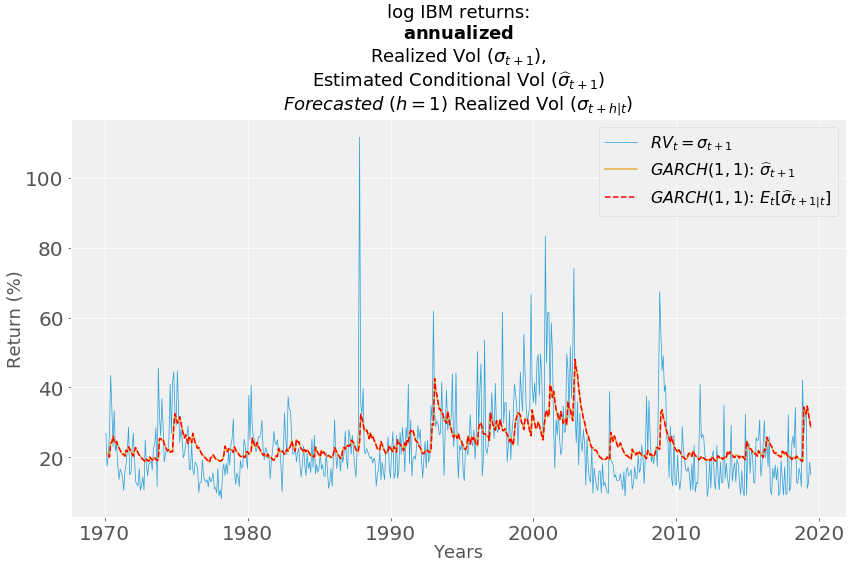

In [44]:
train_enddt = None
test_startdt = ret_eom['IBM'].index.min()

garch11_IBM_dict =_arch_model_est(y=ret_eom['IBM'], y_RV=RVol_m['IBM'], ARCHModel_dict=garch11_dict, 
                                  max_horizon=5, test_startdt=test_startdt, model_name='GARCH(1,1)')

### Discussion 1:

A striking feature of the GARCH($1$,$1$) models for all three equity returns is the magnitude of the GARCH coefficient estimate $\widehat{\beta}$. All GARCH coefficients are very large, indicating strong persistence in estimated volatility. In contrast, the effect of the ARCH term $\widehat{\alpha}$ is relatively weak, with most coefficients ranging between 0.084 and 0.143. The constant in the volatility equation, $\omega$, is relatively large in magnitude for all three models.
 
Also, note the $R^2$ in the estimation output: it is zero for all three equity returns. Why? 
   * The $R^2$ is for the return process, not the volatility of returns. Here, we have a **constant mean** return process, hence no explanatory variables are provided which could explain returns. Returns are modeled as a **constant mean** process  with serially correlated errors, which is consistent with observed dynamics of *monthly* stock returns.
   * If we had an AR($1$) model for returns, then things could be different. However, if the **constant mean** return process is the "correct" one, then the AR($1$) parameter estimated would not be statistically different from zero.
 
### Discussion 2:

For all three equity returns, the ARCH parameter estimates $\widehat{\alpha}$ is between 0.1 and 0.15, while the GARCH parameter estimates $\widehat{\beta}$ ranges from 0.82 to 0.84.

To formally test whether volatility in the GARCH($1$,$1$) models is a non-stationary process, we would want to test the null hypothesis $\mathbf{H}_0: \alpha+ \beta=0$. This results in an $F$-test  (since the restrictions implied by the null are linear). The test will look like:

$$
\begin{align*}
 R\cdot(\alpha, \beta)^\prime = r
\end{align*}
$$
where $R=(1, 1)$ is the restriction matrix and $r=0$.

### Discussion 3:
Volatility <u>can't</u> be a random walk since it is bounded from below from zero. However, it can be non-stationary (a random walk is a type of nonstationary process).

### Discussion 4:
Also, even though the ARCH terms can be statistically insignificant, they should not be thrown out - the GARCH model will break down since it builds on an ARCH model.

### Discussion 5:

Within the entire context of the course, it is important to synthesize and understand how various financial asset dynamics could be modeled. For example:
1. **S&P 500 Index returns** could be modeled as a constant mean, serially correlated error process.
2. **S&P 500 Index volatility** could be modeled as a persistence process using a GARCH($p$,$q$) model w/ $p=1$, and $q=1$ being the common method.
3. **log price/dividend ratio** could be modeled as a stationary process (which we know results from cointegration). The errors of such process will be serially correlated and heteroskedastic.
4. **dividend growth** (monthly) could be modeled as stationary process (almost a $WN$ process, since AR($1$) coefficient is almost zero) with errors that are serially correlated due to seasonalities. However, annual dividend growth (i.e. year-over-year growth) would have close to zero serial correlation since the seasonality is removed.
5. **log dividends** could be modeled as a random walk process.

### OLS regressions:

In addition to comparing realized monthly volatility to GARCH($1$,$1$) conditional volatility estimates via the previous plots, we can run regressions of realized volatility $RVol_t$ on GARCH($1$,$1$) conditional volatility $\widehat{\sigma}_{GARCH(1,1), t}~~$:

$$
\begin{align*}
  RVol_t = a + b ~\widehat{\sigma}_{GARCH(1,1),t} ~~+ \nu_t  
\end{align*}
$$

Even though $\widehat{\sigma}_{GARCH(1,1),t}~~$ is an estimate with uncertainty, we ignore (for now) this uncertainty in the standard errors of $a$ and $b$. Moreover, we can use the time-series of $\{\widehat{\sigma}_{GARCH(1,1),t}~~ \}_{t\geq1}$ to forecast $RVol_t$ $h$-steps ahead, either in-sample or out-of sample. The $h$-step ahead forecast is similar in functional form to the AR($1$) forecasting relation:

$$
\begin{align*}
    RVol_{t+h|t} = a\left(1 + b + b^2 +...+ b^{h-1}\right) + b^h ~\widehat{\sigma}_{GARCH(1,1),t}
\end{align*}
$$

where $RVol_{t+h|t}$ $\left(\text{or }E_t\left[RVol_{t+h} \right]\right)$ denotes the forecast of $RVol_{t+h}$ given all information at time $t$

In [45]:
def compare_rv_condvol(rv, cond_vol, max_horizon=1, addcon=True, cov_type=None, nw_maxlags=1, summary=True):
    """
    PARAM: "rv"
    PARAM: "cond_vol"
    PARAM: "max_horizon"
    """
    
    if addcon:
        X = sm.add_constant(cond_vol)
    else:
        X = cond_vol
    
    if cov_type==None:
        se_type = 'OLS'
        ols_results = sm.OLS(rv, X, missing='drop').fit()
    elif 'HC' in cov_type:
        se_type = 'White'
        ols_results = sm.OLS(rv, X, missing='drop').fit(cov_type=cov_type)
    elif 'HAC'in cov_type: 
        nw_maxlags = 4
        se_type = 'NW('+str(nw_maxlags)+')'
        ols_results = sm.OLS(rv, X, missing='drop').fit(cov_type='HAC', maxlag=nw_maxlags)
    
    if summary:
        print('**** '+rv.name+' ****\n\n', 
              ols_results.summary(yname='RVol-'+rv.name, xname=['a_{'+rv.name+'}', 'b_{'+rv.name+'}']))  
    
    a = ols_results.params[0]
    b = ols_results.params[1:].item()
    ols_resids = ols_results.resid  # resids   
    
    rv_ols_forecasts_h = pd.DataFrame(index=rv.index, columns=list(range(0, max_horizon)))
    MSE, RMSE, MAE = {}, {}, {}  
    for h in range(0, max_horizon+1):
        rep_a = a*np.ones(h)
        b_h = np.array([(b**k) for k in range(0, h)])
        rv_ols_forecasts_h[h] = (np.dot(rep_a, b_h.T) + (b**h)*cond_vol.shift(h))

        ### MSE, RMSE, & MAE        
        error_h = (rv - rv_ols_forecasts_h[h]).dropna()
        T_h = len(error_h) 
        MSE[h] = (1/T_h)*np.sum(error_h**2)
        RMSE[h] = ((1/T_h)*np.sum(error_h**2))**0.5
        MAE[h] = (1/T_h)*np.sum(np.abs(error_h))  
    
    ols_output = {'ols_results': ols_results,
              'se_type': se_type,
              'a': a, 
              'b': b, 
              'a_se': ols_results.bse[0], 
              'b_se': ols_results.bse[1:].item(),
              'a_tstat': ols_results.tvalues[0], 
              'b_tstat': ols_results.tvalues[1:].item(),                 
              'resids': ols_resids,
              'max_forecast_h': max_horizon,
              'rv_ols_forecasts_h': rv_ols_forecasts_h,
              'BIC': ols_results.bic, 'MSE': MSE, 'RMSE': RMSE, 'MAE': MAE} 
    
    return ols_output

In [46]:
y_RV = RVol_m['S&P500'][1:]
cond_vol = garch11_SP500_dict['cond_vol']

rv_SP500_reg = compare_rv_condvol(rv=y_RV, cond_vol=cond_vol, max_horizon=5, cov_type='HC0')


**** S&P500 ****

                             OLS Regression Results                            
Dep. Variable:            RVol-S&P500   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     109.0
Date:                Sat, 18 May 2019   Prob (F-statistic):           1.58e-23
Time:                        19:55:09   Log-Likelihood:                -1287.7
No. Observations:                 592   AIC:                             2579.
Df Residuals:                     590   BIC:                             2588.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
a_{S&P500}    -0.0888      0.383 

/Users/chris.jauregui/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [47]:
y_RV = RVol_m['GE'][1:]
cond_vol = garch11_GE_dict['cond_vol']

rv_GE_reg = compare_rv_condvol(rv=y_RV, cond_vol=cond_vol, max_horizon=5, cov_type='HC0')

**** GE ****

                             OLS Regression Results                            
Dep. Variable:                RVol-GE   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     105.0
Date:                Sat, 18 May 2019   Prob (F-statistic):           8.61e-23
Time:                        19:55:09   Log-Likelihood:                -1554.1
No. Observations:                 592   AIC:                             3112.
Df Residuals:                     590   BIC:                             3121.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
a_{GE}         0.4645      0.601     

In [48]:
y_RV = RVol_m['IBM'][1:]
cond_vol = garch11_IBM_dict['cond_vol']

rv_IBM_reg = compare_rv_condvol(rv=y_RV, cond_vol=cond_vol, max_horizon=5, cov_type='HC0')

**** IBM ****

                             OLS Regression Results                            
Dep. Variable:               RVol-IBM   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     103.7
Date:                Sat, 18 May 2019   Prob (F-statistic):           1.49e-22
Time:                        19:55:09   Log-Likelihood:                -1457.3
No. Observations:                 592   AIC:                             2919.
Df Residuals:                     590   BIC:                             2927.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
a_{IBM}       -1.5590      0.773    

We can put together all of our results into one table:

In [49]:
row_midx = pd.MultiIndex.from_product([list(RVol_m.columns), ['$\widehat{a}$', '$\widehat{b}$']], names=['ticker', 'param'])
se_type = '$White$'
rv_reg_table = pd.DataFrame(index=row_midx, columns=['estimate', '$SE$(estimate)_'+se_type, '$t$(estimate)_'+se_type])
for ticker in RVol_m.columns:
    df_ticker_name = 'rv_' + ticker.replace('&','') + '_reg'  
    rv_reg_table.loc[ticker, '$\widehat{a}$'] = [locals()[df_ticker_name]['a'], locals()[df_ticker_name]['a_se'], 
                                                 locals()[df_ticker_name]['a_tstat']] 
    rv_reg_table.loc[ticker, '$\widehat{b}$'] = [locals()[df_ticker_name]['b'], locals()[df_ticker_name]['b_se'], 
                                                 locals()[df_ticker_name]['b_tstat']]  
    

In [50]:
display(rv_reg_table)

estimate $SE$(estimate)_$White$ $t$(estimate)_$White$
ticker param                                                              
S&P500 $\widehat{a}$   -0.089                  0.383                -0.232
       $\widehat{b}$    0.992                  0.095                10.440
GE     $\widehat{a}$    0.464                  0.601                 0.773
       $\widehat{b}$    0.898                  0.088                10.248
IBM    $\widehat{a}$   -1.559                  0.773                -2.016
       $\widehat{b}$    1.191                  0.117                10.186

Let's also compute the **MSE**, **RMSE**, and **MAE** for the in-sample predictions implied by this **OLS regression**.

In [51]:
max_horizon = max(rv_SP500_reg['max_forecast_h'], rv_GE_reg['max_forecast_h'], rv_IBM_reg['max_forecast_h'])
row_midx = pd.MultiIndex.from_product([list(range(0, max_horizon+1)), ['MSE', 'RMSE', 'MAE']], names=['h-step', 'metric'])

garch11_ols_model_eval = pd.DataFrame(index=row_midx, columns=RVol_m.columns)
for h in range(0, max_horizon+1):
    garch11_ols_model_eval.loc[h, ['S&P500']] = np.array([rv_SP500_reg[x][h] for x in ['MSE', 'RMSE', 'MAE']])
    garch11_ols_model_eval.loc[h, ['GE']] = np.array([rv_GE_reg[x][h] for x in ['MSE', 'RMSE', 'MAE']])
    garch11_ols_model_eval.loc[h, ['IBM']] = np.array([rv_IBM_reg[x][h] for x in ['MSE', 'RMSE', 'MAE']])

garch11_ols_model_eval  = pd.concat([garch11_ols_model_eval], axis=1, keys=['$RVol$ on $GARCH(1,1)$ cond. vol'])   

In [52]:
display(garch11_ols_model_eval)

$RVol$ on $GARCH(1,1)$ cond. vol              
                                        S&P500     GE    IBM
h-step metric                                               
0      MSE                               4.553 11.322  8.170
       RMSE                              2.134  3.365  2.858
       MAE                               1.305  2.348  2.027
1      MSE                               5.132 12.062  8.643
       RMSE                              2.265  3.473  2.940
       MAE                               1.365  2.357  2.023
2      MSE                               5.519 13.120  9.513
       RMSE                              2.349  3.622  3.084
       MAE                               1.400  2.408  2.087
3      MSE                               5.902 14.129 11.276
       RMSE                              2.429  3.759  3.358
       MAE                               1.451  2.476  2.288
4      MSE                               6.084 14.716 13.142
       RMSE                              2.466  3.836  3.625
       MAE                               1.467  2.491  2.499
5      MSE                               6.328 15.390 16.439
       RMSE                              2.516  3.923  4.054
       MAE                               1.488  2.503  2.943

### Discussion:

For all three equity returns, GARCH($1$,$1$) conditional volatility helps predict realized volatility in the univariate specification under consideration. 

**Note:** Future exercises could include lagged realized volatility to assess whether GARCH($1$,$1$) conditional volatility **Granger-causes** realized volatility. 

# Exercise 3: 
Compute the **MSE**, **RMSE**, and **MAE** of the GARCH($1,1$)-implied $h$-period ahead forecasts, with $h=1,2,3,4,5$.

In [53]:
max_horizon = max(garch11_SP500_dict['max_forecast_h'], garch11_GE_dict['max_forecast_h'], garch11_IBM_dict['max_forecast_h'])
row_midx = pd.MultiIndex.from_product([list(range(1, max_horizon+1)), ['MSE', 'RMSE', 'MAE']], names=['h-step', 'metric'])

garch11_model_eval = pd.DataFrame(index=row_midx, columns=RVol_m.columns)
for h in range(1, max_horizon+1):
    garch11_model_eval.loc[h, ['S&P500']] = np.array([garch11_SP500_dict[x][h] for x in ['MSE', 'RMSE', 'MAE']])
    garch11_model_eval.loc[h, ['GE']] = np.array([garch11_GE_dict
                                                  
                                                  [x][h] for x in ['MSE', 'RMSE', 'MAE']])
    garch11_model_eval.loc[h, ['IBM']] = np.array([garch11_IBM_dict[x][h] for x in ['MSE', 'RMSE', 'MAE']])

garch11_model_eval  = pd.concat([garch11_model_eval], axis=1, keys=['$GARCH(1,1)$ model'])    

In [54]:
display(garch11_model_eval)

$GARCH(1,1)$ model               
                          S&P500      GE    IBM
h-step metric                                  
1      MSE                 2.062 110.419 31.428
       RMSE                1.436  10.508  5.606
       MAE                 1.216  10.221  5.440
2      MSE                 1.919 111.030 31.358
       RMSE                1.385  10.537  5.600
       MAE                 1.175  10.271  5.458
3      MSE                 1.788 111.563 31.289
       RMSE                1.337  10.562  5.594
       MAE                 1.136  10.316  5.474
4      MSE                 1.668 112.020 31.219
       RMSE                1.292  10.584  5.587
       MAE                 1.100  10.357  5.486
5      MSE                 1.558 112.395 31.149
       RMSE                1.248  10.602  5.581
       MAE                 1.065  10.394  5.495

## Exercise 3 (Addendum):

Revisit the GARCH($1$,$1$) model and compute GARCH($1$,$1$)-implied, $h$-period out-of-sample (oos) forecasts for the **S&P 500 Index**, **GE**, and **IBM**. 

Consider $h=1,2,3,4,5$ as a starting point. How do the **MSE**, **RMSE**, and **MAE** compare across $h$?

#### Note:
Work with the sample period from lecture: **1/3/1990 - 12/31/2017**
* Training/Estimation period: **1/3/1990 - 12/31/2009**
* Testing/Out-of-sample period: **1/2/2010 - 12/31/2017**


### Solution to Exercise 3 (Addendum): 

Let's use the previously-defined function `_arch_model_est`

In [55]:
garch11_dict = {'mean': 'Constant', 'lags': 0, 'vol': 'GARCH', 'p': 1, 'o': 0, 'q': 1, 'dist': 'Normal', 
                'freq': 'M', 'disp': 'off'}

train_enddt = dt.datetime(2009,12,31)
test_startdt = dt.datetime(2009,12,31)


**** S&P500 ****

                      Constant Mean - GARCH Model Results                      
Dep. Variable:                 S&P500   R-squared:                      -0.002
Mean Model:             Constant Mean   Adj. R-squared:                 -0.002
Vol Model:                      GARCH   Log-Likelihood:               -669.995
Distribution:                  Normal   AIC:                           1347.99
Method:            Maximum Likelihood   BIC:                           1361.90
                                        No. Observations:                  239
Date:                Sat, May 18 2019   Df Residuals:                      235
Time:                        19:55:10   Df Model:                            4
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.6513      0.233      2.795  5.183

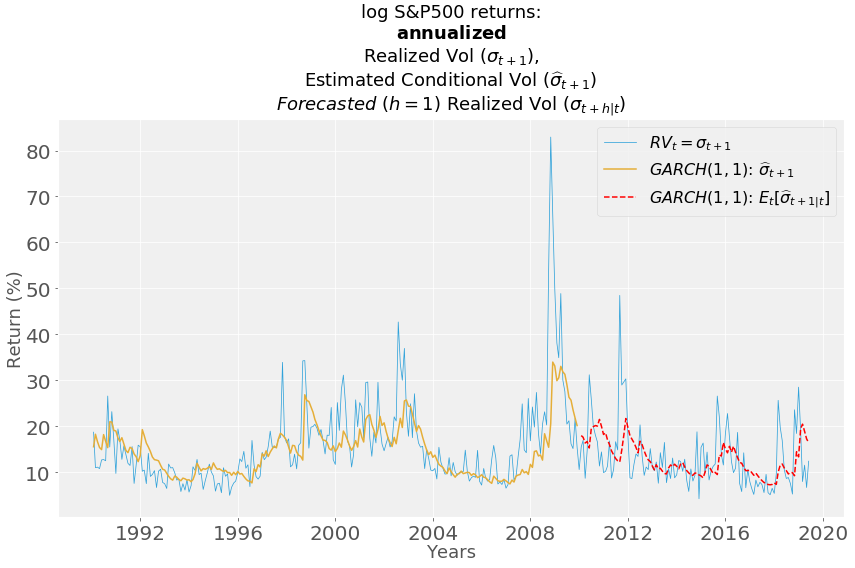

In [56]:
y    = ret_eom['S&P500']['1990':]
y_RV = RVol_m['S&P500']['1990':]

garch11_SP500_dict_oos =_arch_model_est(y=y, y_RV=y_RV, ARCHModel_dict=garch11_dict, max_horizon=5, 
                                        train_enddt=train_enddt, test_startdt=test_startdt, model_name='GARCH(1,1)')



**** GE ****

                      Constant Mean - GARCH Model Results                      
Dep. Variable:                     GE   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -812.213
Distribution:                  Normal   AIC:                           1632.43
Method:            Maximum Likelihood   BIC:                           1646.33
                                        No. Observations:                  239
Date:                Sat, May 18 2019   Df Residuals:                      235
Time:                        19:55:11   Df Model:                            4
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.8240      0.434      4.198  2.689e-05

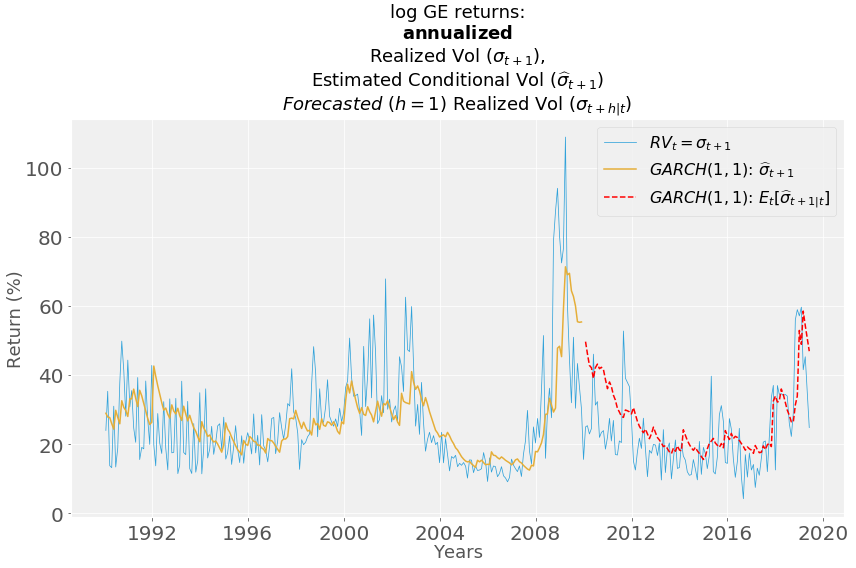

In [57]:
y    = ret_eom['GE']['1990':]
y_RV = RVol_m['GE']['1990':]

garch11_GE_dict_oos =_arch_model_est(y=y, y_RV=y_RV, ARCHModel_dict=garch11_dict, max_horizon=5, 
                                     train_enddt=train_enddt, test_startdt=test_startdt, model_name='GARCH(1,1)')


**** IBM ****

                      Constant Mean - GARCH Model Results                      
Dep. Variable:                    IBM   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -847.044
Distribution:                  Normal   AIC:                           1702.09
Method:            Maximum Likelihood   BIC:                           1715.99
                                        No. Observations:                  239
Date:                Sat, May 18 2019   Df Residuals:                      235
Time:                        19:55:12   Df Model:                            4
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.4191      0.504      2.818  4.834e-0

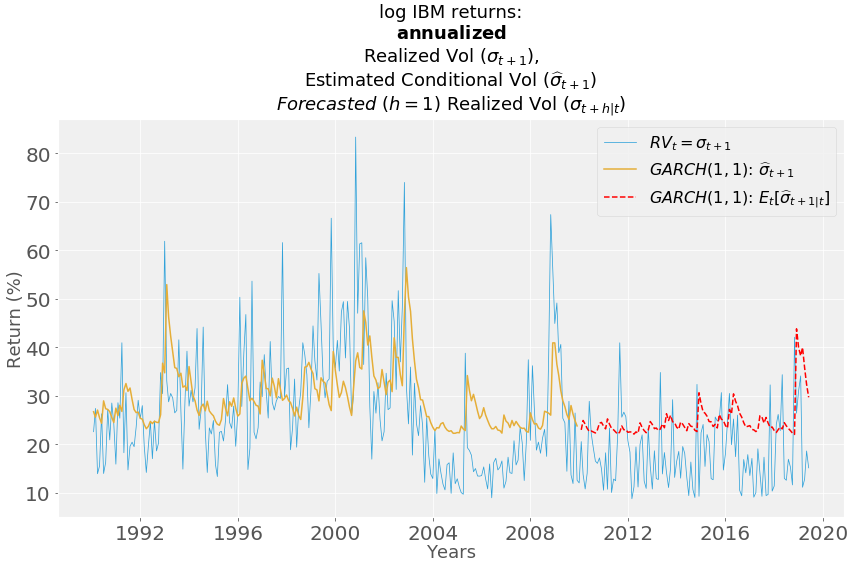

In [58]:
y    = ret_eom['IBM']['1990':]
y_RV = RVol_m['IBM']['1990':]

garch11_IBM_dict_oos =_arch_model_est(y=y, y_RV=y_RV, ARCHModel_dict=garch11_dict, max_horizon=5, 
                                      train_enddt=train_enddt, test_startdt=test_startdt, model_name='GARCH(1,1)')

Let's look at the $GARCH(1,1)$-implied **MSE**, **RMSE**, and **MAE** from the forecasts:

In [59]:
max_horizon = max(garch11_SP500_dict_oos['max_forecast_h'], garch11_GE_dict_oos['max_forecast_h'], 
                  garch11_IBM_dict_oos['max_forecast_h'])
row_midx = pd.MultiIndex.from_product([list(range(1, max_horizon+1)), ['MSE', 'RMSE', 'MAE']], names=['h-step', 'metric'])

garch11_model_eval_oos = pd.DataFrame(index=row_midx, columns=RVol_m.columns)
for h in range(1, max_horizon+1):
    garch11_model_eval_oos.loc[h, ['S&P500']] = np.array([garch11_SP500_dict_oos[x][h] for x in ['MSE', 'RMSE', 'MAE']])
    garch11_model_eval_oos.loc[h, ['GE']] = np.array([garch11_GE_dict_oos[x][h] for x in ['MSE', 'RMSE', 'MAE']])
    garch11_model_eval_oos.loc[h, ['IBM']] = np.array([garch11_IBM_dict_oos[x][h] for x in ['MSE', 'RMSE', 'MAE']])

garch11_model_eval_oos  = pd.concat([garch11_model_eval_oos], axis=1, keys=['$GARCH(1,1)$ model' ])        

In [60]:
display(garch11_model_eval_oos)

$GARCH(1,1)$ model               
                          S&P500      GE    IBM
h-step metric                                  
1      MSE                 5.034 172.085 14.384
       RMSE                2.244  13.118  3.793
       MAE                 1.973  12.807  3.638
2      MSE                 5.176 172.372 15.834
       RMSE                2.275  13.129  3.979
       MAE                 2.020  12.831  3.870
3      MSE                 5.305 172.243 17.107
       RMSE                2.303  13.124  4.136
       MAE                 2.063  12.845  4.060
4      MSE                 5.407 171.698 18.196
       RMSE                2.325  13.103  4.266
       MAE                 2.101  12.847  4.214
5      MSE                 5.478 170.638 19.105
       RMSE                2.341  13.063  4.371
       MAE                 2.134  12.837  4.339


# Exercise 4:

Repeat the above exercise for the GJR-GARCH($1$,$1$) model:

$$
\begin{align*}
    \sigma_t^2 = \omega + ~\alpha ~\epsilon_{t-1}^2 + ~\gamma ~\epsilon_{t-1}^2 I_{\{\epsilon_{t-1}<0 \}} + \beta ~\sigma_{t-1}^2 .
\end{align*}
$$

## Solution to Exercise 4: 

Using the `arch` package again, we now need to be more specific about the arguments passed to `arch_model`. Per the [online documentation](https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_modeling.html), we now have to set `o=1`. 

We can use our function `_arch_model_est`.


In [61]:
gjr11_dict = {'mean': 'Constant', 'lags': 0, 'vol': 'GARCH', 'p': 1, 'o': 1, 'q': 1, 'dist': 'Normal', 
              'freq': 'M', 'disp': 'off'}



**** S&P500 ****

                    Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                 S&P500   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -1684.87
Distribution:                  Normal   AIC:                           3379.73
Method:            Maximum Likelihood   BIC:                           3401.65
                                        No. Observations:                  592
Date:                Sat, May 18 2019   Df Residuals:                      587
Time:                        19:55:13   Df Model:                            5
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.5712      0.160      3.560  3.704

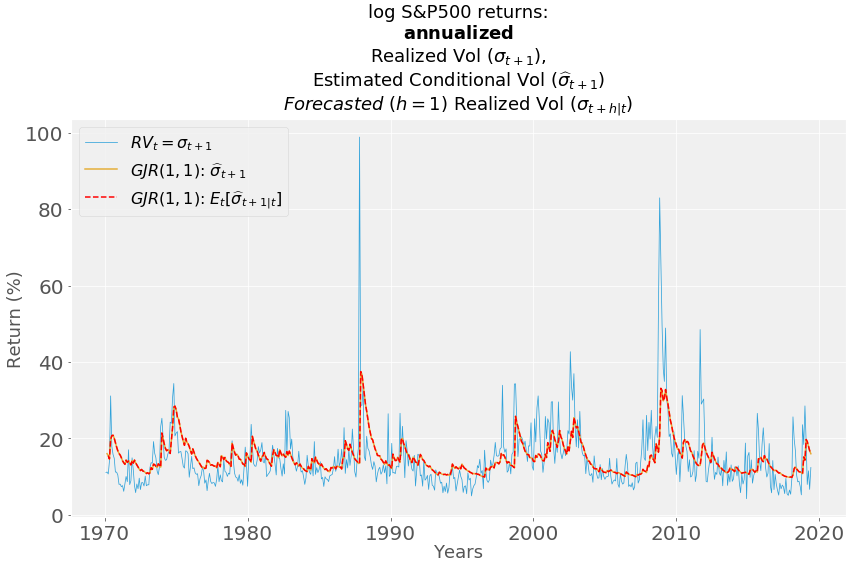

In [62]:
train_enddt = None
test_startdt = ret_eom['S&P500'].index.min()

gjr11_SP500_dict =_arch_model_est(y=ret_eom['S&P500'], y_RV=RVol_m['S&P500'], ARCHModel_dict=gjr11_dict, 
                                  max_horizon=5, test_startdt=test_startdt, model_name='GJR(1,1)')



**** GE ****

                    Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                     GE   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -2012.54
Distribution:                  Normal   AIC:                           4035.09
Method:            Maximum Likelihood   BIC:                           4057.01
                                        No. Observations:                  592
Date:                Sat, May 18 2019   Df Residuals:                      587
Time:                        19:55:13   Df Model:                            5
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.3840      0.292      4.745  2.086e-06

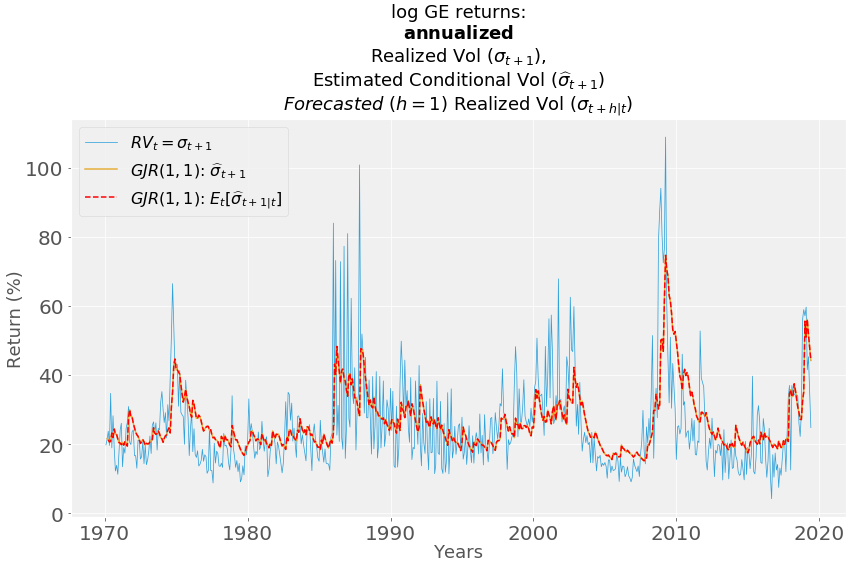

In [63]:

train_enddt = None
test_startdt = ret_eom['GE'].index.min()

gjr11_GE_dict =_arch_model_est(y=ret_eom['GE'], y_RV=RVol_m['GE'], ARCHModel_dict=gjr11_dict, 
                              max_horizon=5, test_startdt=test_startdt, model_name='GJR(1,1)')


**** IBM ****

                    Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                    IBM   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -1975.46
Distribution:                  Normal   AIC:                           3960.91
Method:            Maximum Likelihood   BIC:                           3982.83
                                        No. Observations:                  592
Date:                Sat, May 18 2019   Df Residuals:                      587
Time:                        19:55:14   Df Model:                            5
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.6846      0.259      2.648  8.092e-0

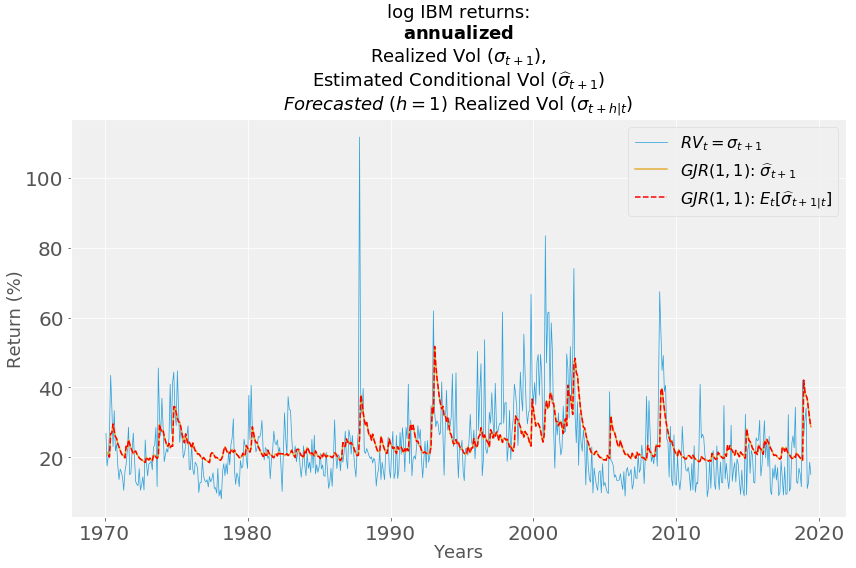

In [64]:
train_enddt = None
test_startdt = ret_eom['IBM'].index.min()

gjr11_IBM_dict =_arch_model_est(y=ret_eom['IBM'], y_RV=RVol_m['IBM'], ARCHModel_dict=gjr11_dict, 
                              max_horizon=5, test_startdt=test_startdt, model_name='GJR(1,1)')

### Discussion 1:

There are several striking features of the GJR-GARCH($1$,$1$) models for the three equity returns. For the **SP500 Index**, $\widehat{\alpha}$ and $\widehat{\gamma}$ are not statistically different from zero at the 5% significance level. The magnitude of $\widehat{\alpha}$ is twice as large as $\widehat{\gamma}$ suggesting the  **SP500 Index** return time-series is mostly driven by negative shocks. The same goes for **GE** and **IBM**.

To formally test if positive shocks are significant, then the test will have the null $\mathbf{H}_0:\alpha=0$. To test the significance of negative shocks, the null hypothesis is $\mathbf{H}_0:\alpha + \gamma=0$, which implies an $F$-test.

### Discussion 2:

In terms of forecasting, the GJR-GARCH($1$,$1$) model is quantitatively similar to those from the GARCH($1$,$1$) model: not much improvement. The difference lies in understanding the dynamics of the underlying dynamics of volatility. A GJR-GARCH($1$,$1$) model hones in on the contribution of positive and negative shocks to conditional volatility, while the GARCH($1$,$1$) model just pools them together. This difference doesn't matter when we want to forecast. 

### OLS regressions:

In addition to comparing realized monthly volatility to GJR-GARCH($1$,$1$) conditional volatility estimates via the previous plots, we can run regressions of realized volatility $RVol_t$ on GJR-GARCH($1$,$1$) conditional volatility $\widehat{\sigma}_{GJR-GARCH(1,1),t}~~$:

$$
\begin{align*}
  RVol_t = a + b~\widehat{\sigma}_{GJR-GARCH(1,1),t} ~~~ + \nu_t  
\end{align*}
$$

Even though $\widehat{\sigma}_{GJR-GARCH(1,1),t}~~~$ is an estimate with uncertainty, we ignore (for now) this uncertainty in the standard errors of $a$ and $b$. Similar to the GARCH($1$, $1$) model, we can use the time-series of $\{\widehat{\sigma}_{GJR-GARCH(1,1),t}~~~ \}_{t\geq1}$ to forecast $RVol_t$ $h$-steps ahead, either in-sample or out-of sample: 

$$
\begin{align*}
    RVol_{t+h|t} = a\left(1 + b + b^2 +...+ b^{h-1}\right) + b^h ~\widehat{\sigma}_{GJR-GARCH(1,1),t}
\end{align*}
$$


In [65]:
y_RV = RVol_m['S&P500'][1:]
cond_vol = gjr11_SP500_dict['cond_vol']

rv_SP500_reg = compare_rv_condvol(rv=y_RV, cond_vol=cond_vol, max_horizon=5, cov_type='HC0')

**** S&P500 ****

                             OLS Regression Results                            
Dep. Variable:            RVol-S&P500   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     109.5
Date:                Sat, 18 May 2019   Prob (F-statistic):           1.26e-23
Time:                        19:55:14   Log-Likelihood:                -1271.0
No. Observations:                 592   AIC:                             2546.
Df Residuals:                     590   BIC:                             2555.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
a_{S&P500}    -0.2771      0.406 

/Users/chris.jauregui/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [66]:
y_RV = RVol_m['GE'][1:]
cond_vol = gjr11_GE_dict['cond_vol']

rv_GE_reg = compare_rv_condvol(rv=y_RV, cond_vol=cond_vol, max_horizon=5, cov_type='HC0')

**** GE ****

                             OLS Regression Results                            
Dep. Variable:                RVol-GE   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     123.5
Date:                Sat, 18 May 2019   Prob (F-statistic):           3.52e-26
Time:                        19:55:15   Log-Likelihood:                -1539.2
No. Observations:                 592   AIC:                             3082.
Df Residuals:                     590   BIC:                             3091.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
a_{GE}         0.2285      0.578     

In [67]:
y_RV = RVol_m['IBM'][1:]
cond_vol = gjr11_IBM_dict['cond_vol']

rv_IBM_reg = compare_rv_condvol(rv=y_RV, cond_vol=cond_vol, max_horizon=5, cov_type='HC0')

**** IBM ****

                             OLS Regression Results                            
Dep. Variable:               RVol-IBM   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     98.01
Date:                Sat, 18 May 2019   Prob (F-statistic):           1.76e-21
Time:                        19:55:15   Log-Likelihood:                -1456.8
No. Observations:                 592   AIC:                             2918.
Df Residuals:                     590   BIC:                             2926.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
a_{IBM}       -0.8692      0.728    

In [68]:
row_midx = pd.MultiIndex.from_product([list(RVol_m.columns), ['$\widehat{a}$', '$\widehat{b}$']], names=['ticker', 'param'])
se_type = '$White$'
rv_reg_table = pd.DataFrame(index=row_midx, columns=['estimate', '$SE$(estimate)_'+se_type, '$t$(estimate)_'+se_type])
for ticker in RVol_m.columns:
    df_ticker_name = 'rv_' + ticker.replace('&','') + '_reg'  
    rv_reg_table.loc[ticker, '$\widehat{a}$'] = [locals()[df_ticker_name]['a'], locals()[df_ticker_name]['a_se'], 
                                                 locals()[df_ticker_name]['a_tstat']] 
    rv_reg_table.loc[ticker, '$\widehat{b}$'] = [locals()[df_ticker_name]['b'], locals()[df_ticker_name]['b_se'], 
                                                 locals()[df_ticker_name]['b_tstat']]  
    

In [69]:
display(rv_reg_table)

estimate $SE$(estimate)_$White$ $t$(estimate)_$White$
ticker param                                                              
S&P500 $\widehat{a}$   -0.277                  0.406                -0.683
       $\widehat{b}$    1.041                  0.099                10.465
GE     $\widehat{a}$    0.229                  0.578                 0.395
       $\widehat{b}$    0.932                  0.084                11.112
IBM    $\widehat{a}$   -0.869                  0.728                -1.195
       $\widehat{b}$    1.093                  0.110                 9.900

Let's also compute the **MSE**, **RMSE**, and **MAE** for the in-sample predictions implied by this **OLS regression**.

In [70]:
max_horizon = max(rv_SP500_reg['max_forecast_h'], rv_GE_reg['max_forecast_h'], rv_IBM_reg['max_forecast_h'])
row_midx = pd.MultiIndex.from_product([list(range(0, max_horizon+1)), ['MSE', 'RMSE', 'MAE']], names=['h-step', 'metric'])

gjr11_ols_model_eval = pd.DataFrame(index=row_midx, columns=RVol_m.columns)
for h in range(0, max_horizon+1):
    gjr11_ols_model_eval.loc[h, ['S&P500']] = np.array([rv_SP500_reg[x][h] for x in ['MSE', 'RMSE', 'MAE']])
    gjr11_ols_model_eval.loc[h, ['GE']] = np.array([rv_GE_reg[x][h] for x in ['MSE', 'RMSE', 'MAE']])
    gjr11_ols_model_eval.loc[h, ['IBM']] = np.array([rv_IBM_reg[x][h] for x in ['MSE', 'RMSE', 'MAE']])

gjr11_ols_model_eval  = pd.concat([gjr11_ols_model_eval], axis=1, keys=['$RVol_t$ on $GJR(1,1)$ cond. vol'])   

In [71]:
display(gjr11_ols_model_eval)

$RVol_t$ on $GJR(1,1)$ cond. vol              
                                        S&P500     GE    IBM
h-step metric                                               
0      MSE                               4.301 10.723  8.106
       RMSE                              2.074  3.275  2.847
       MAE                               1.256  2.287  2.032
1      MSE                               5.032 11.765  8.935
       RMSE                              2.243  3.430  2.989
       MAE                               1.351  2.339  2.058
2      MSE                               5.558 13.007  9.660
       RMSE                              2.358  3.607  3.108
       MAE                               1.416  2.404  2.117
3      MSE                               6.062 14.059 10.897
       RMSE                              2.462  3.750  3.301
       MAE                               1.477  2.492  2.234
4      MSE                               6.381 14.736 11.853
       RMSE                              2.526  3.839  3.443
       MAE                               1.519  2.524  2.328
5      MSE                               6.796 15.565 13.130
       RMSE                              2.607  3.945  3.624
       MAE                               1.571  2.547  2.497

# Exercise 5: 
Compute the **MSE**, **RMSE**, and **MAE** of the GJR-GARCH($1,1$) $h$-period ahead forecasts, with $h=1,2,3,4,5$.

In [72]:
max_horizon = max(gjr11_SP500_dict['max_forecast_h'], gjr11_GE_dict['max_forecast_h'], gjr11_IBM_dict['max_forecast_h'])
row_midx = pd.MultiIndex.from_product([list(range(1, max_horizon+1)), ['MSE', 'RMSE', 'MAE']], names=['h-step', 'metric'])

gjr11_model_eval = pd.DataFrame(index=row_midx, columns=RVol_m.columns)
for h in range(1, max_horizon+1):
    gjr11_model_eval.loc[h, ['S&P500']] = np.array([gjr11_SP500_dict[x][h] for x in ['MSE', 'RMSE', 'MAE']])
    gjr11_model_eval.loc[h, ['GE']] = np.array([gjr11_GE_dict[x][h] for x in ['MSE', 'RMSE', 'MAE']])
    gjr11_model_eval.loc[h, ['IBM']] = np.array([gjr11_IBM_dict[x][h] for x in ['MSE', 'RMSE', 'MAE']])

gjr11_model_eval  = pd.concat([gjr11_model_eval], axis=1, keys=['$GJR(1,1)$ model'])    

In [73]:
display(gjr11_model_eval)

$GJR(1,1)$ model               
                        S&P500      GE    IBM
h-step metric                                
1      MSE               2.200 110.064 31.733
       RMSE              1.483  10.491  5.633
       MAE               1.276  10.193  5.435
2      MSE               2.010 110.779 31.624
       RMSE              1.418  10.525  5.624
       MAE               1.226  10.249  5.462
3      MSE               1.843 111.414 31.524
       RMSE              1.358  10.555  5.615
       MAE               1.180  10.299  5.484
4      MSE               1.696 111.973 31.429
       RMSE              1.302  10.582  5.606
       MAE               1.138  10.345  5.500
5      MSE               1.566 112.448 31.338
       RMSE              1.251  10.604  5.598
       MAE               1.099  10.387  5.513

## Exercise 5 (Addendum):

Revisit the GJR-GARCH($1$,$1$) model and compute GJR-GARCH($1$,$1$)-implied, $h$-period out-of-sample (oos) forecasts for the **S&P 500 Index**, **GE**, and **IBM**. 

Consider $h=1,2,3,4,5$ as a starting point. How do the **MSE**, **RMSE**, and **MAE** compare across $h$?

#### Note:
Work with the sample period from lecture: **1/3/1990 - 12/31/2017**
* Training/Estimation period: **1/3/1990 - 12/31/2009**
* Testing/Out-of-sample period: **1/2/2010 - 12/31/2017**


### Solution to Exercise 5 (Addendum): 

Let's use the previously-defined function `_arch_model_est`

In [74]:
gjr11_dict = {'mean': 'Constant', 'lags': 0, 'vol': 'GARCH', 'p': 1, 'o': 1, 'q': 1, 'dist': 'Normal', 
              'freq': 'M', 'disp': 'off'}

train_enddt = dt.datetime(2009,12,31)
test_startdt = dt.datetime(2009,12,31)


**** S&P500 ****

                    Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                 S&P500   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                  GJR-GARCH   Log-Likelihood:               -669.434
Distribution:                  Normal   AIC:                           1348.87
Method:            Maximum Likelihood   BIC:                           1366.25
                                        No. Observations:                  239
Date:                Sat, May 18 2019   Df Residuals:                      234
Time:                        19:55:15   Df Model:                            5
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.5901      0.225      2.622  8.733

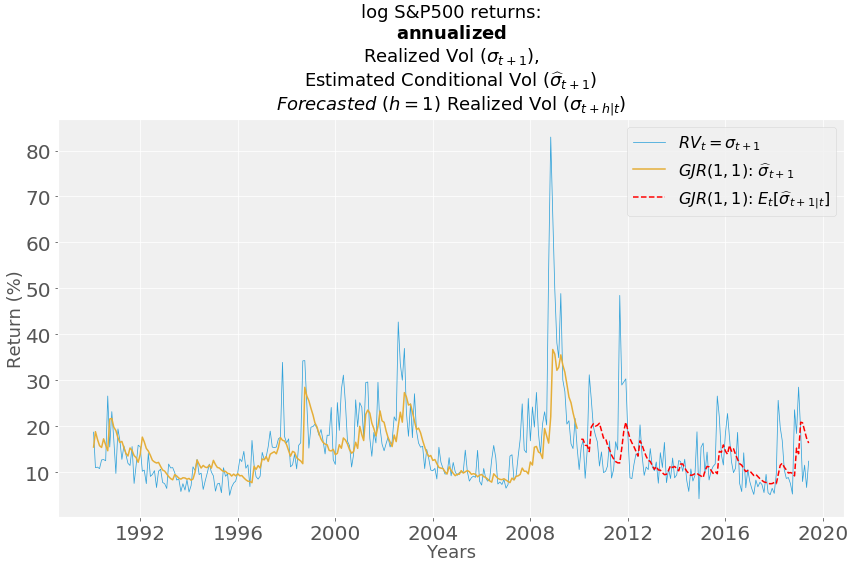

In [75]:
y    = ret_eom['S&P500']['1990':]
y_RV = RVol_m['S&P500']['1990':]

gjr11_SP500_dict_oos =_arch_model_est(y=y, y_RV=y_RV, ARCHModel_dict=gjr11_dict, max_horizon=5, 
                                      train_enddt=train_enddt, test_startdt=test_startdt, model_name='GJR(1,1)')



**** GE ****

                    Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                     GE   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                  GJR-GARCH   Log-Likelihood:               -810.924
Distribution:                  Normal   AIC:                           1631.85
Method:            Maximum Likelihood   BIC:                           1649.23
                                        No. Observations:                  239
Date:                Sat, May 18 2019   Df Residuals:                      234
Time:                        19:55:16   Df Model:                            5
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.8021      0.488      3.689  2.251e-04

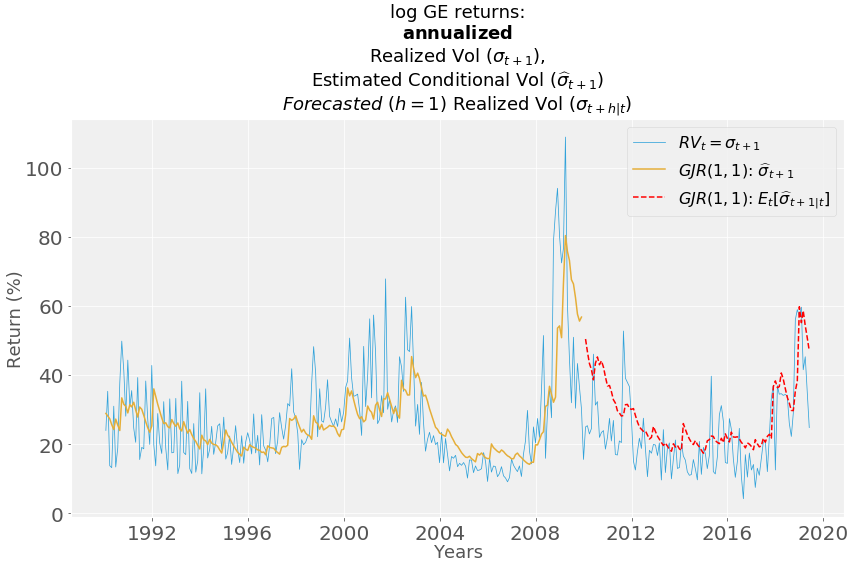

In [76]:
y    = ret_eom['GE']['1990':]
y_RV = RVol_m['GE']['1990':]

gjr11_GE_dict_oos =_arch_model_est(y=y, y_RV=y_RV, ARCHModel_dict=gjr11_dict, max_horizon=5, 
                                   train_enddt=train_enddt, test_startdt=test_startdt, model_name='GJR(1,1)')


**** IBM ****

                    Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                    IBM   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -845.421
Distribution:                  Normal   AIC:                           1700.84
Method:            Maximum Likelihood   BIC:                           1718.22
                                        No. Observations:                  239
Date:                Sat, May 18 2019   Df Residuals:                      234
Time:                        19:55:16   Df Model:                            5
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.2283      0.513      2.394  1.667e-0

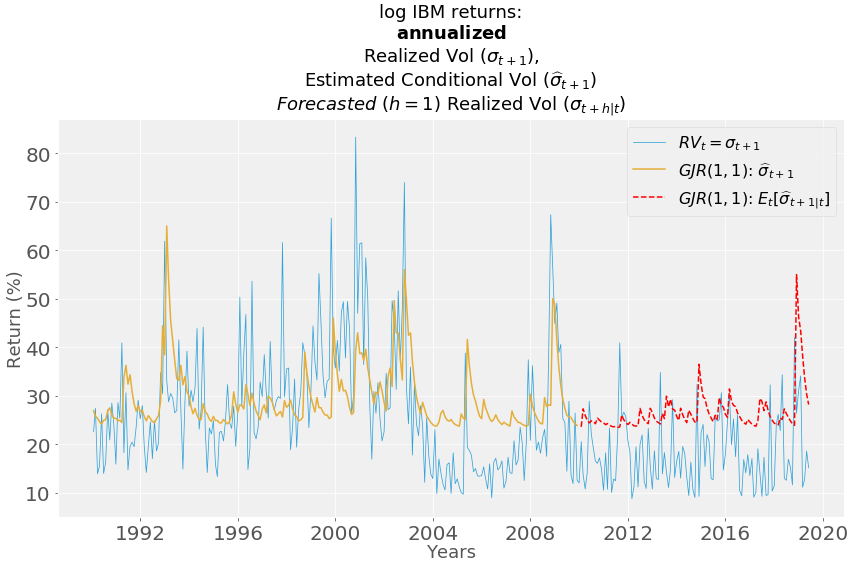

In [77]:
y    = ret_eom['IBM']['1990':]
y_RV = RVol_m['IBM']['1990':]

gjr11_IBM_dict_oos =_arch_model_est(y=y, y_RV=y_RV, ARCHModel_dict=gjr11_dict, max_horizon=5, 
                                    train_enddt=train_enddt, test_startdt=test_startdt, model_name='GJR(1,1)')

Let's look at **MSE**, **RMSE**, and **MAE** of the GJR-GARCH($1$,$1$)-implied forecasts:

In [78]:
max_horizon = max(gjr11_SP500_dict_oos['max_forecast_h'], gjr11_GE_dict_oos['max_forecast_h'], 
                  gjr11_IBM_dict_oos['max_forecast_h'])
row_midx = pd.MultiIndex.from_product([list(range(1, max_horizon+1)), ['MSE', 'RMSE', 'MAE']], names=['h-step', 'metric'])

gjr11_model_eval_oos = pd.DataFrame(index=row_midx, columns=RVol_m.columns)
for h in range(1, max_horizon+1):
    gjr11_model_eval_oos.loc[h, ['S&P500']] = np.array([gjr11_SP500_dict_oos[x][h] for x in ['MSE', 'RMSE', 'MAE']])
    gjr11_model_eval_oos.loc[h, ['GE']] = np.array([gjr11_GE_dict_oos[x][h] for x in ['MSE', 'RMSE', 'MAE']])
    gjr11_model_eval_oos.loc[h, ['IBM']] = np.array([gjr11_IBM_dict_oos[x][h] for x in ['MSE', 'RMSE', 'MAE']])

gjr11_model_eval_oos  = pd.concat([gjr11_model_eval_oos], axis=1, keys=['$GJR(1,1)$ model'])   

In [79]:
display(gjr11_model_eval_oos)

$GJR(1,1)$ model               
                        S&P500      GE    IBM
h-step metric                                
1      MSE               4.804 181.692 18.963
       RMSE              2.192  13.479  4.355
       MAE               1.926  13.157  4.162
2      MSE               4.878 181.668 20.273
       RMSE              2.209  13.478  4.503
       MAE               1.964  13.174  4.384
3      MSE               4.939 181.252 21.332
       RMSE              2.222  13.463  4.619
       MAE               1.998  13.179  4.545
4      MSE               4.972 180.470 22.161
       RMSE              2.230  13.434  4.708
       MAE               2.026  13.174  4.662
5      MSE               4.975 179.207 22.790
       RMSE              2.231  13.387  4.774
       MAE               2.048  13.158  4.747

# Exercise 6:

First, compare the **MSE**, **RMSE**, and **MAE** of AR($1$)-, GARCH($1$,$1$)-,and GJR-GARCH($1$,$1$)-implied forecasts with respect to both the in-sample and out-of-sample $h$-step ahead predictions.

Then, compare the **MSE**, **RMSE**, and **MAE** of AR($1$)-implied (in-sample) forecasts with those from the **OLS regressions** which included  GARCH($1$,$1$) and GJR-GARCH($1$,$1$) conditional volatility as predictors for current and future realized volatility $RVol$.

Both comparisons will not be identical! (Why?)

## Solution to Exercise 6:

Let's aggregate the tables from previous analysis.

#### AR($1$)-, GARCH($1$,$1$)-, and GJR-GARCH($1$,$1$)-implied forecasts (In-sample):

In [80]:
table_compare = ar1_model_eval.merge(garch11_model_eval, on=['h-step', 'metric'], how='inner').\
                                     merge(gjr11_model_eval, on=['h-step', 'metric'], how='inner')

table_compare.sort_values(by=['h-step'], axis=0)

$AR(1)$               $GARCH(1,1)$ model                 \
               S&P500     GE    IBM             S&P500      GE    IBM   
h-step metric                                                           
1      MSE      3.603 10.912  7.705              2.062 110.419 31.428   
       RMSE     1.898  3.303  2.776              1.436  10.508  5.606   
       MAE      1.097  2.199  1.883              1.216  10.221  5.440   
2      MSE      4.506 12.172  8.831              1.919 111.030 31.358   
       RMSE     2.123  3.489  2.972              1.385  10.537  5.600   
       MAE      1.282  2.394  2.079              1.175  10.271  5.458   
3      MSE      5.068 13.359  9.352              1.788 111.563 31.289   
       RMSE     2.251  3.655  3.058              1.337  10.562  5.594   
       MAE      1.358  2.509  2.163              1.136  10.316  5.474   
4      MSE      5.529 14.886 10.190              1.668 112.020 31.219   
       RMSE     2.351  3.858  3.192              1.292  10.584  5.587   
       MAE      1.450  2.662  2.277              1.100  10.357  5.486   
5      MSE      5.616 15.442 10.394              1.558 112.395 31.149   
       RMSE     2.370  3.930  3.224              1.248  10.602  5.581   
       MAE      1.476  2.728  2.309              1.065  10.394  5.495   

              $GJR(1,1)$ model                 
                        S&P500      GE    IBM  
h-step metric                                  
1      MSE               2.200 110.064 31.733  
       RMSE              1.483  10.491  5.633  
       MAE               1.276  10.193  5.435  
2      MSE               2.010 110.779 31.624  
       RMSE              1.418  10.525  5.624  
       MAE               1.226  10.249  5.462  
3      MSE               1.843 111.414 31.524  
       RMSE              1.358  10.555  5.615  
       MAE               1.180  10.299  5.484  
4      MSE               1.696 111.973 31.429  
       RMSE              1.302  10.582  5.606  
       MAE               1.138  10.345  5.500  
5      MSE               1.566 112.448 31.338  
       RMSE              1.251  10.604  5.598  
       MAE               1.099  10.387  5.513

#### AR($1$)-implied, OLS-implied (w/ GARCH($1$,$1$) and GJR-GARCH($1$,$1$) conditional volatility) forecasts (In-sample):

In [97]:
ols_table_compare = ar1_model_eval.reset_index().merge(garch11_ols_model_eval.reset_index(), 
                                                       on=['h-step', 'metric'], how='outer').set_index(['h-step', 'metric'])

ols_table_compare = ols_table_compare.reset_index().merge(gjr11_ols_model_eval.reset_index(), 
                                                       on=['h-step', 'metric'], how='outer').set_index(['h-step', 'metric'])

ols_table_compare.sort_values(by=['h-step'], axis=0)

/Users/chris.jauregui/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


$AR(1)$               $RVol$ on $GARCH(1,1)$ cond. vol         \
               S&P500     GE    IBM                           S&P500     GE   
h-step metric                                                                 
0      MAE        NaN    NaN    NaN                            1.305  2.348   
       MSE        NaN    NaN    NaN                            4.553 11.322   
       RMSE       NaN    NaN    NaN                            2.134  3.365   
1      MSE      3.603 10.912  7.705                            5.132 12.062   
       MAE      1.097  2.199  1.883                            1.365  2.357   
       RMSE     1.898  3.303  2.776                            2.265  3.473   
2      RMSE     2.123  3.489  2.972                            2.349  3.622   
       MAE      1.282  2.394  2.079                            1.400  2.408   
       MSE      4.506 12.172  8.831                            5.519 13.120   
3      MSE      5.068 13.359  9.352                            5.902 14.129   
       RMSE     2.251  3.655  3.058                            2.429  3.759   
       MAE      1.358  2.509  2.163                            1.451  2.476   
4      MSE      5.529 14.886 10.190                            6.084 14.716   
       RMSE     2.351  3.858  3.192                            2.466  3.836   
       MAE      1.450  2.662  2.277                            1.467  2.491   
5      MSE      5.616 15.442 10.394                            6.328 15.390   
       RMSE     2.370  3.930  3.224                            2.516  3.923   
       MAE      1.476  2.728  2.309                            1.488  2.503   

                     $RVol_t$ on $GJR(1,1)$ cond. vol                
                 IBM                           S&P500     GE    IBM  
h-step metric                                                        
0      MAE     2.027                            1.256  2.287  2.032  
       MSE     8.170                            4.301 10.723  8.106  
       RMSE    2.858                            2.074  3.275  2.847  
1      MSE     8.643                            5.032 11.765  8.935  
       MAE     2.023                            1.351  2.339  2.058  
       RMSE    2.940                            2.243  3.430  2.989  
2      RMSE    3.084                            2.358  3.607  3.108  
       MAE     2.087                            1.416  2.404  2.117  
       MSE     9.513                            5.558 13.007  9.660  
3      MSE    11.276                            6.062 14.059 10.897  
       RMSE    3.358                            2.462  3.750  3.301  
       MAE     2.288                            1.477  2.492  2.234  
4      MSE    13.142                            6.381 14.736 11.853  
       RMSE    3.625                            2.526  3.839  3.443  
       MAE     2.499                            1.519  2.524  2.328  
5      MSE    16.439                            6.796 15.565 13.130  
       RMSE    4.054                            2.607  3.945  3.624  
       MAE     2.943                            1.571  2.547  2.497

### Discussion:

We  see the results for all three models are close. The AR($1$) model sometimes results in slightly smaller **RMSE** and **MAE**. The AR($1$) and GARCH($1$,$1$) models are reasonable options since they relatively more parsimonious than the GJR-GARCH($1$,$1$) model. 

#### AR($1$)-, GARCH($1$,$1$)-, and GJR-GARCH($1$,$1$)-implied forecasts (Out-of-sample):

In [82]:
table_compare_oos = ar1_model_eval.merge(garch11_model_eval_oos, on=['h-step', 'metric'], how='inner').\
                                     merge(gjr11_model_eval_oos, on=['h-step', 'metric'], how='inner')

table_compare_oos.sort_values(by=['h-step'], axis=0)

$AR(1)$               $GARCH(1,1)$ model                 \
               S&P500     GE    IBM             S&P500      GE    IBM   
h-step metric                                                           
1      MSE      3.603 10.912  7.705              5.034 172.085 14.384   
       RMSE     1.898  3.303  2.776              2.244  13.118  3.793   
       MAE      1.097  2.199  1.883              1.973  12.807  3.638   
2      MSE      4.506 12.172  8.831              5.176 172.372 15.834   
       RMSE     2.123  3.489  2.972              2.275  13.129  3.979   
       MAE      1.282  2.394  2.079              2.020  12.831  3.870   
3      MSE      5.068 13.359  9.352              5.305 172.243 17.107   
       RMSE     2.251  3.655  3.058              2.303  13.124  4.136   
       MAE      1.358  2.509  2.163              2.063  12.845  4.060   
4      MSE      5.529 14.886 10.190              5.407 171.698 18.196   
       RMSE     2.351  3.858  3.192              2.325  13.103  4.266   
       MAE      1.450  2.662  2.277              2.101  12.847  4.214   
5      MSE      5.616 15.442 10.394              5.478 170.638 19.105   
       RMSE     2.370  3.930  3.224              2.341  13.063  4.371   
       MAE      1.476  2.728  2.309              2.134  12.837  4.339   

              $GJR(1,1)$ model                 
                        S&P500      GE    IBM  
h-step metric                                  
1      MSE               4.804 181.692 18.963  
       RMSE              2.192  13.479  4.355  
       MAE               1.926  13.157  4.162  
2      MSE               4.878 181.668 20.273  
       RMSE              2.209  13.478  4.503  
       MAE               1.964  13.174  4.384  
3      MSE               4.939 181.252 21.332  
       RMSE              2.222  13.463  4.619  
       MAE               1.998  13.179  4.545  
4      MSE               4.972 180.470 22.161  
       RMSE              2.230  13.434  4.708  
       MAE               2.026  13.174  4.662  
5      MSE               4.975 179.207 22.790  
       RMSE              2.231  13.387  4.774  
       MAE               2.048  13.158  4.747

# Example 7: Principal Component Analysis (PCA)

In this example, we'll look at the **PCA** decomposition of the following sets of large firms' stock returns:
1. Financial firms 
2. Energy firms, 
3. Consumer non-durables firms. 

We'll look at **PCA** using both correlation and covariance matrices.

Recall that the $j^{th}$ PC of $\mathbf{x}$ is the linear combination $y_j = \mathbf{w_j} \mathbf{x}$ that maximizes $Var(y_j)$ subject to:

* $\mathbf{w_j}' \mathbf{w_j} = 1$
* $Cov(y_i, y_j) = 0$ for $i=1, \ldots, j-1$

**PCA** is nothing more than an eigenvalue-eigenvector decomposition of the variance-covariance of a given data matrix $\mathbf{x}$, which will have $N>T$ i.e. more-cross-sectional observations than time-series components. 

We can use the package `sklearn`, which is Python's "machine-learning" toolkit. Specifically, we can use [`sklearn.decomposition.PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). We can also use the `statsmodels` version of PCA, which is part of the subroutine `statsmodels.multivariate.pca`. For some more information about PCA using Python see [here](https://plot.ly/ipython-notebooks/principal-component-analysis/).

Let's prepare the .csv files that we will be using. First, we will get the stock symbols of the largest firms in these three sectors from three .csv files:

In [83]:
#### Get largest companies in Finance, Energy, Consumer Non-Durables

### Finance Sector 
df = pd.read_csv('./companylist_finance.csv')
df.sort_values('MarketCap', inplace=True, ascending=False)
finance_syms = df['Symbol'].values[:20]

### Energy Sector
df = pd.read_csv('./companylist_energy.csv')
df.sort_values('MarketCap', inplace=True, ascending=False)
energy_syms = df['Symbol'].values[:20]

### Consumer non-durables
df = pd.read_csv('./companylist_cons_nond.csv')
df.sort_values('MarketCap', inplace=True, ascending=False)
cons_syms = df['Symbol'].values[:20]

### combined symbols
company_syms = np.r_[finance_syms, energy_syms, cons_syms]
print(company_syms)

['JPM' 'WFC' 'BAC' 'HSBC' 'C' 'RY' 'SAN' 'LFC' 'GS' 'USB' 'TD' 'MTU'
 'ITUB' 'MS' 'WBK' 'HDB' 'AXP' 'BSBR' 'BNS' 'LYG' 'XOM' 'GE' 'CVX' 'TOT'
 'PTR' 'BP' 'SLB' 'SNP' 'BBL' 'PBR' 'ENB' 'E' 'STO' 'COP' 'EOG' 'SU' 'OXY'
 'HAL' 'PSX' 'EMR' 'BUD' 'KO' 'PM' 'PEP' 'MO' 'BTI' 'KHC' 'ABEV' 'RAI'
 'NKE' 'DEO' 'MDLZ' 'CL' 'SNE' 'STZ' 'EL' 'FMX' 'GIS' 'SYY' 'TEL']


Now, we will load our stock price data obtained from **CRSP** (you can retrieve the data remotely using the `wrds` API describe in **Lab 1B**):

In [84]:
### Load stock prices

dfcrsp = pd.read_csv('./crsp_sic.csv', parse_dates=['date'])
dfcrsp = dfcrsp.dropna()
dfcrsp = dfcrsp[dfcrsp['RET'] != 'C']
dfcrsp['RET'] = dfcrsp['RET'].astype('float')

    
display(dfcrsp.info())
multi_table([dfcrsp.head(), dfcrsp.tail()])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18964 entries, 0 to 19172
Data columns (total 5 columns):
PERMNO    18964 non-null int64
date      18964 non-null datetime64[ns]
SICCD     18964 non-null float64
TICKER    18964 non-null object
RET       18964 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 888.9+ KB


None

Let's keep returns after 1995 and do some more cleaning.

In [85]:
dfcrsp = dfcrsp[dfcrsp.date >'1995']
dfcrsp2 = dfcrsp.pivot_table(index='date', columns='TICKER', values='RET')

### Sort companies: financials, energy, consumer
dfcrsp2 = dfcrsp2.loc[:,company_syms]

### fix names
for sym in finance_syms:
    dfcrsp2.rename(columns={sym:'fin_'+sym}, inplace=True)
for sym in energy_syms:
    dfcrsp2.rename(columns={sym:'energy_'+sym}, inplace=True)
for sym in cons_syms:
    dfcrsp2.rename(columns={sym:'cons_'+sym}, inplace=True)
dfcrsp2.head()

Y = dfcrsp2.dropna(axis=1, how='any')
display(Y.head())

/Users/chris.jauregui/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


TICKER      fin_JPM  fin_WFC  fin_BAC  fin_WBK  fin_AXP  energy_GE  \
date                                                                 
1995-01-31    0.122    0.024    0.092    0.007    0.068      0.010   
1995-02-28    0.024    0.090    0.127    0.073    0.067      0.063   
1995-03-31   -0.043   -0.026    0.003   -0.048    0.037     -0.006   
1995-04-28    0.076    0.068    0.026    0.057    0.003      0.037   
1995-05-31    0.080    0.109    0.062   -0.014    0.022      0.036   

TICKER      energy_TOT  energy_SLB  energy_EOG  energy_SU  ...  energy_EMR  \
date                                                       ...               
1995-01-31      -0.038       0.047      -0.052      0.044  ...       0.010   
1995-02-28      -0.022       0.084       0.176      0.037  ...       0.056   
1995-03-31       0.081       0.048       0.180      0.094  ...       0.006   
1995-04-28       0.046       0.055      -0.070      0.070  ...       0.011   
1995-05-31       0.014       0.040       0.060     -0.004  ...       0.029   

TICKER      cons_KO  cons_PEP  cons_MO  cons_BTI  cons_NKE  cons_CL  cons_SNE  \
date                                                                            
1995-01-31    0.019     0.017    0.039     0.046    -0.049   -0.001    -0.163   
1995-02-28    0.048     0.061    0.017    -0.062     0.012    0.026    -0.072   
1995-03-31    0.029     0.005    0.090     0.115     0.047    0.023     0.127   
1995-04-28    0.031     0.064    0.036     0.053     0.022    0.071     0.041   
1995-05-31    0.060     0.177    0.076     0.042     0.029    0.096    -0.037   

TICKER      cons_GIS  cons_SYY  
date                            
1995-01-31    -0.001     0.058  
1995-02-28     0.071     0.046  
1995-03-31    -0.016    -0.066  
1995-04-28     0.031     0.061  
1995-05-31     0.040    -0.031  

[5 rows x 22 columns]

Let's look at correlations across stocks:

In [86]:
display(Y.corr())

TICKER      fin_JPM  fin_WFC  fin_BAC  fin_WBK  fin_AXP  energy_GE  \
TICKER                                                               
fin_JPM       1.000    0.576    0.696    0.428    0.559      0.488   
fin_WFC       0.576    1.000    0.673    0.304    0.555      0.479   
fin_BAC       0.696    0.673    1.000    0.427    0.528      0.540   
fin_WBK       0.428    0.304    0.427    1.000    0.374      0.461   
fin_AXP       0.559    0.555    0.528    0.374    1.000      0.567   
energy_GE     0.488    0.479    0.540    0.461    0.567      1.000   
energy_TOT    0.263    0.251    0.227    0.455    0.265      0.338   
energy_SLB    0.344    0.238    0.256    0.408    0.375      0.371   
energy_EOG    0.169    0.230    0.137    0.195    0.272      0.218   
energy_SU     0.255    0.242    0.261    0.486    0.335      0.311   
energy_OXY    0.274    0.287    0.229    0.358    0.266      0.282   
energy_HAL    0.348    0.178    0.215    0.417    0.393      0.339   
energy_EMR    0.416    0.362    0.357    0.466    0.534      0.513   
cons_KO       0.300    0.274    0.225    0.346    0.302      0.292   
cons_PEP      0.325    0.313    0.330    0.353    0.325      0.391   
cons_MO       0.165    0.146    0.101    0.166    0.158      0.168   
cons_BTI      0.199    0.162    0.134    0.295    0.194      0.236   
cons_NKE      0.343    0.369    0.297    0.301    0.351      0.365   
cons_CL       0.241    0.283    0.187    0.300    0.285      0.376   
cons_SNE      0.289    0.103    0.257    0.322    0.322      0.383   
cons_GIS      0.106    0.147    0.106    0.113    0.106      0.220   
cons_SYY      0.261    0.406    0.249    0.281    0.383      0.366   

TICKER      energy_TOT  energy_SLB  energy_EOG  energy_SU  ...  energy_EMR  \
TICKER                                                     ...               
fin_JPM          0.263       0.344       0.169      0.255  ...       0.416   
fin_WFC          0.251       0.238       0.230      0.242  ...       0.362   
fin_BAC          0.227       0.256       0.137      0.261  ...       0.357   
fin_WBK          0.455       0.408       0.195      0.486  ...       0.466   
fin_AXP          0.265       0.375       0.272      0.335  ...       0.534   
energy_GE        0.338       0.371       0.218      0.311  ...       0.513   
energy_TOT       1.000       0.581       0.466      0.621  ...       0.409   
energy_SLB       0.581       1.000       0.552      0.624  ...       0.418   
energy_EOG       0.466       0.552       1.000      0.521  ...       0.396   
energy_SU        0.621       0.624       0.521      1.000  ...       0.380   
energy_OXY       0.668       0.558       0.561      0.654  ...       0.410   
energy_HAL       0.510       0.701       0.491      0.550  ...       0.373   
energy_EMR       0.409       0.418       0.396      0.380  ...       1.000   
cons_KO          0.242       0.113       0.048      0.200  ...       0.312   
cons_PEP         0.260       0.208       0.117      0.143  ...       0.294   
cons_MO          0.162       0.095       0.152      0.146  ...       0.266   
cons_BTI         0.351       0.218       0.286      0.282  ...       0.326   
cons_NKE         0.225       0.213       0.206      0.243  ...       0.400   
cons_CL          0.161       0.179       0.062      0.178  ...       0.308   
cons_SNE         0.308       0.319       0.145      0.312  ...       0.283   
cons_GIS         0.055      -0.015       0.095     -0.042  ...       0.207   
cons_SYY         0.284       0.203       0.193      0.214  ...       0.412   

TICKER      cons_KO  cons_PEP  cons_MO  cons_BTI  cons_NKE  cons_CL  cons_SNE  \
TICKER                                                                          
fin_JPM       0.300     0.325    0.165     0.199     0.343    0.241     0.289   
fin_WFC       0.274     0.313    0.146     0.162     0.369    0.283     0.103   
fin_BAC       0.225     0.330    0.101     0.134     0.297    0.187     0.257   
fin_WBK       0.346     0.353    0.166   

Let's initialize `sklearn.decomposition.PCA` and focus on the first 9 principal components of our large stock return dataset for the 3 industries.

In [87]:
from sklearn.decomposition import PCA

pca_sk = PCA(n_components=9).fit(Y.values)
pca_summary = pd.DataFrame()
name_ls = ['value', 'Difference', 'Proportion', 'Cumulative value', 'Cumulative proportion']

pca_summary['value'] = pca_sk.explained_variance_
pca_summary['Difference'] = pca_summary.value.diff(-1)
pca_summary['Proportion'] = pca_sk.explained_variance_ratio_
pca_summary['Cumulative value'] = pca_summary.value.cumsum()
pca_summary['Cumulative Proportion'] = pca_summary.Proportion.cumsum()
pca_summary.round(4)

value  Difference  Proportion  Cumulative value  Cumulative Proportion
0  0.053       0.034       0.361             0.053                  0.361
1  0.019       0.008       0.132             0.072                  0.493
2  0.012       0.003       0.080             0.084                  0.573
3  0.009       0.003       0.061             0.093                  0.634
4  0.006       0.000       0.043             0.099                  0.678
5  0.006       0.000       0.040             0.105                  0.718
6  0.006       0.001       0.039             0.111                  0.757
7  0.004       0.001       0.031             0.115                  0.788
8  0.004         nan       0.026             0.119                  0.815

Let's decompose the correlation and covariance matrices of our data matrix $\mathbf{x}$ now using `statsmodels`:

In [88]:
### Correlation PCA
pca_corr = multivariate.pca.PCA(Y, standardize=True)

### Covariance PCA
pca_cov = multivariate.pca.PCA(Y, standardize=False)

Let's look at the loadings of some stocks for both decompositions of the first 5 principal components:

In [89]:
multi_table([pca_corr.loadings.iloc[:,:5], pca_cov.loadings.iloc[:,:5]])

Let's first focus on the factors obtained from the PC decomposition of the **covariance** matrix. Let's look at the first 3 PC factors.

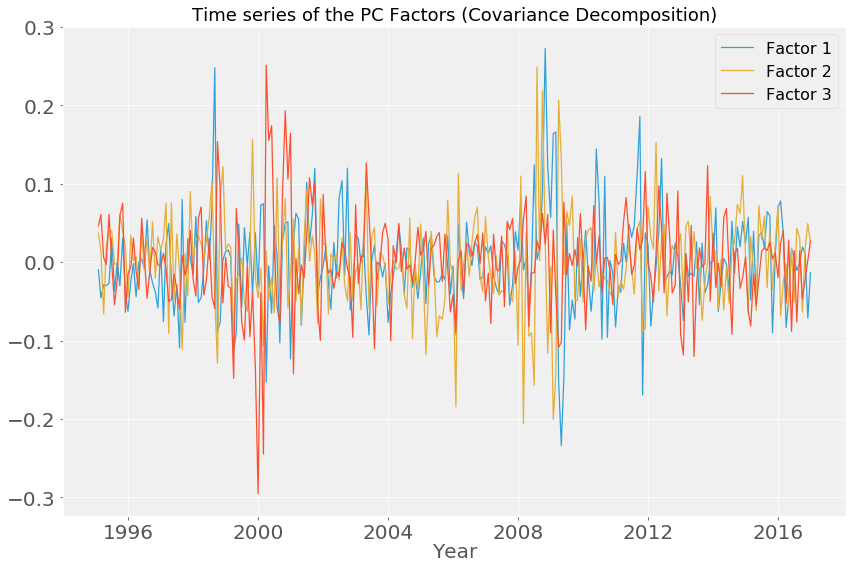

In [90]:
num_pcfactors = 3
fig, axes = plt.subplots(figsize=(12,8))
axes.plot(pca_cov.factors.iloc[:,:num_pcfactors], lw=1.25)
axes.set_xlabel('Year', fontsize=20)
axes.set_title('Time series of the PC Factors (Covariance Decomposition)', fontsize=18) 
axes.legend(['Factor 1', 'Factor 2',  'Factor 3'], fontsize=16, loc='best')
fig.tight_layout()     

We can also look at the $R^2$ and plot the eigenvalues from the **covariance** decomposition.

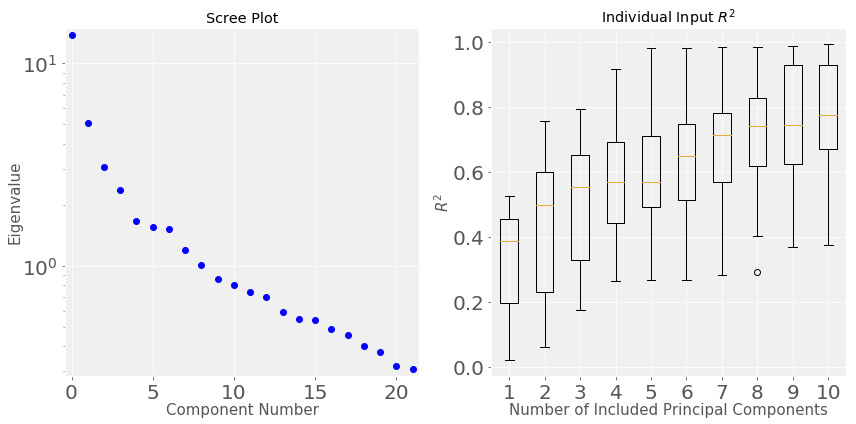

In [91]:
### R-squared and eigenvalue plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
pca_cov.plot_scree(ax=axes[0])
pca_cov.plot_rsquare(ax=axes[1])
fig.tight_layout()

Let's now focus on the factors obtained from the PC decomposition of the **correlation** matrix. Let's look at the first 3 PC factors.

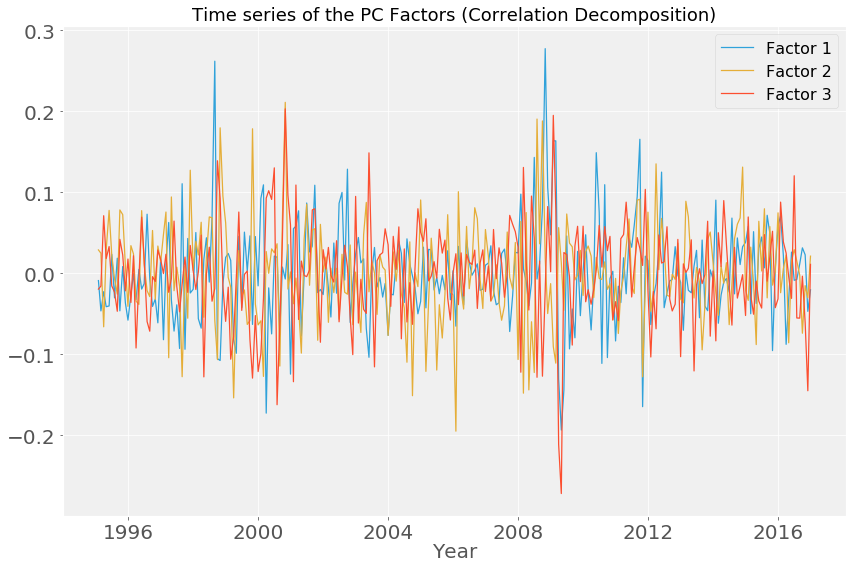

In [92]:
num_pcfactors = 3
fig, axes = plt.subplots(figsize=(12,8))
axes.plot(pca_corr.factors.iloc[:,:num_pcfactors], lw=1.25)
axes.set_xlabel('Year', fontsize=20)
axes.set_title('Time series of the PC Factors (Correlation Decomposition)', fontsize=18) 
axes.legend(['Factor 1', 'Factor 2',  'Factor 3'], fontsize=16, loc='best')
fig.tight_layout()  

We can also look at the $R^2$ and plot the eigenvalues from the **correlation** decomposition.

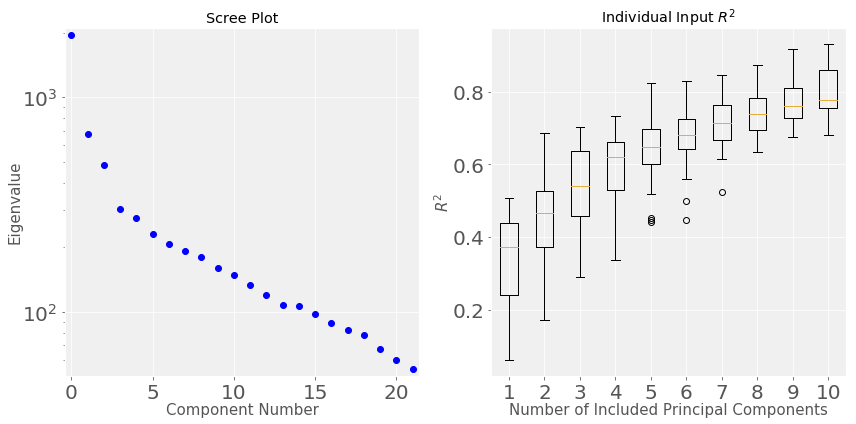

In [93]:
### R-squared and eigenvalue plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
pca_corr.plot_scree(ax=axes[0])
pca_corr.plot_rsquare(ax=axes[1])
fig.tight_layout()

That is all for today! 😎